A notebook which will contain plots showing data summaries for every year combined.

In [2]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import inspect
import math
from scipy.stats import linregress
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [4]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/kflanaga/MEOPAR/savedData/WADE_nutribot_pickles'

In [5]:
display(Markdown('''## All years Summary ## '''))

## All years Summary ## 

In [6]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [7]:
##### Loading in pickle file data
dictbot=dict()

for Y in years:
    with open(os.path.join(datadir,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictbot[Y]=pickle.load(hh)
    
data=pd.concat(dictbot.values(), ignore_index=True)

In [8]:
#There are a couple of observed ammonium values that are absurdly high above the average value.
#These next bits of code are meant to erase those values. 
for e,i in enumerate(data.Amm):
    if i > 15:
        data.Amm.replace(i,float("NaN"),inplace=True)
        
for e,i in enumerate(data.Amm[data.Basin == 'Hood Canal Basin']):
    if i > 9:
        data.Amm.replace(i,float("NaN"),inplace=True)

# dictionaries that contain relevant subsets ofthe data.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]  
    
datyear=dict()
for iyear in range(2008,2020):
    datyear[iyear] = data.loc[data.Year==iyear]

In [9]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data.Z<15)
DJFd=dict()
MAMd=dict()
JJAd=dict()
SONd=dict()
for i in range(2008,2020):
    DJFd[i]=data.loc[iz&(data.dtUTC>=dt.datetime(i-1,12,1))&(data.dtUTC<=dt.datetime(i,3,1)),:]
    MAMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,6,1))&(data.dtUTC>dt.datetime(i,3,1)),:]
    JJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,6,1)),:]
    SONd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1))&(data.dtUTC<=dt.datetime(i,11,30)),:]
DJF=pd.concat(DJFd.values(), ignore_index=True)
MAM=pd.concat(MAMd.values(), ignore_index=True)
JJA=pd.concat(JJAd.values(), ignore_index=True)
SON=pd.concat(SONd.values(), ignore_index=True)
#DJF=pd.concat((DFJ,data.loc[iz&(data.dtUTC>=dt.datetime(2007,1,1))&(data.dtUTC<=dt.datetime(2007,2,30)),:]),ignore_index=True)
#MAM=pd.concat((MAM,data.loc[iz&(data.dtUTC>=dt.datetime(2007,,1))&(data.dtUTC<=dt.datetime(2007,11,30)),:]),ignore_index=True)
#DJF=pd.concat((DFJ,data.loc[iz&(data.dtUTC>=dt.datetime(2007,10,1))&(data.dtUTC<=dt.datetime(2007,11,30)),:]),ignore_index=True)
#DJF=pd.concat((DFJ,data.loc[iz&(data.dtUTC>=dt.datetime(2007,10,1))&(data.dtUTC<=dt.datetime(2007,11,30)),:]),ignore_index=True)

In [10]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, DJF':DJF,
                      'z < 15 m, MAM':MAM,
                      'z < 15 m, JJA':JJA,
                      'z < 15 m, SON': SON,})

In [11]:
#Creating a list of regions so that they appear in graphs and tables in
#My preferred order
regions=['Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin',
         'Whidbey Basin','Strait of Georgia','Strait of Juan de Fuca']

#Creating dictionaries of regions. 
for iregion in regions:
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

yearsubs=OrderedDict({
                      })
for iyear in range(2008,2020):
    yearsubs[iyear]=datyear[iyear]
yearsubs.keys()

odict_keys([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [12]:
#Defining a couple of additional functions that are specific to this notebook
def ratio_hist2d(ax,fig,df,var1,var2,lims,fontsize=18):
    ax.plot(lims,lims,'k-',alpha=.2)
    ii=(~np.isnan(df[var1]))&(~np.isnan(df[var2]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[var1]].values.flatten(),
                                      df.loc[ii,[var2]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
    ax.set_xlim((0,40))
    ax.set_ylim((0,120))
    ax.set_ylabel(f'{var1}',fontsize=fontsize)
    ax.set_xlabel(f'{var2}',fontsize=fontsize)
    plt.tight_layout()
    return ps  

def byRegion_ratio_hist2d(df,regions,obsvar1,obsvar2,modvar1,modvar2,fontsize=16):
    fig,ax=plt.subplots(math.ceil(len(regions)),2,figsize=(19,56))
    for ri,axi in zip(regions,ax):
        ii=(~np.isnan(df[obsvar1]))&(~np.isnan(df[obsvar2]))&(df['Basin'] == ri)
        counts, xedges, yedges, ps=axi[0].hist2d(df.loc[ii,[obsvar1]].values.flatten(),
                                          df.loc[ii,[obsvar2]].values.flatten(),bins=25*3,norm=LogNorm())
        cb=fig.colorbar(ps,ax=axi[0],label='Count',shrink=0.5)
        axi[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
        axi[0].set_xlim((0,40))
        axi[0].set_ylim((0,120))
        axi[0].set_title(f'Observed Ratio for {ri}')
        axi[0].set_xlabel(f'{obsvar1}',fontsize=fontsize)
        axi[0].set_ylabel(f'{obsvar2}',fontsize=fontsize)
        ii=(~np.isnan(df[modvar1]))&(~np.isnan(df[modvar2]))&(df['Basin'] == ri)
        counts, xedges, yedges, ps=axi[1].hist2d(df.loc[ii,[modvar1]].values.flatten(),
                                          df.loc[ii,[modvar2]].values.flatten(),bins=25*3,norm=LogNorm())
        cb=fig.colorbar(ps,ax=axi[1],label='Count',shrink=0.5)
        axi[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
        axi[1].set_xlim((0,40))
        axi[1].set_ylim((0,120))
        axi[1].set_title(f'Modeled Ratio for {ri}')
        axi[1].set_xlabel(f'{modvar1}',fontsize=fontsize)
        axi[1].set_ylabel(f'{modvar2}',fontsize=fontsize)
    return ps  

def ErrErr_hist2d(df,fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    ii=(~np.isnan(df[obsvar1]))&(~np.isnan(df[modvar1]))&(~np.isnan(df[obsvar2]))&(~np.isnan(df[modvar2]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[modvar1]].values.flatten()-df.loc[ii,[obsvar1]].values.flatten(),
                            df.loc[ii,[modvar2]].values.flatten()-df.loc[ii,[obsvar2]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return cb

def hist2d_err(ax,fig,df,envvar,modvar,obsvar):
    ii=(~np.isnan(df[envvar]))&(~np.isnan(df[modvar]))&(~np.isnan(df[obsvar]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[envvar]].values.flatten(),
                                      df.loc[ii,[modvar]].values.flatten()-df.loc[ii,[obsvar]].values.flatten()
                                         ,bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,shrink=0.8)
    ax.set_ylabel('Modeled')
    ax.set_xlabel('Observed')
    plt.tight_layout()
    return ps

In [13]:
def displayStats(statdict,level='Subset',suborder=None):
    # stats dict starting from variable level
    cols={'Subset':('Subset','Metric',''),
          'Variable':('Variable','Subset','Metric',''),
          'Year':('Year','Variable','Subset','Metric','')}
    ind={'Subset':['Order','Subset','Metric'],
         'Variable':['Variable','Order','Subset','Metric'],
         'Year':['Variable','Subset','Metric']}
    pcols={'Subset':['Metric'],
           'Variable':['Metric'],
           'Year':['Year','Metric']}
    allrows=et._flatten_nested_dict(statdict)
    tdf=pd.DataFrame(allrows,columns=cols[level])
    if suborder is not None:
        subD={suborder[ii]: ii for ii in range(0,len(suborder))}
        tdf['Order']=[subD[tdf['Subset'][ii]] for ii in range(0,len(tdf['Subset']))]
    tdf.set_index(ind[level],inplace=True)
    tbl=pd.pivot_table(tdf,index=ind[level][:-1],columns=pcols[level]).rename_axis(index={'Order':None},columns={'Metric':None})
    cols2=[('','mmean'),('','Bias'),('','RMSE'),('','WSS'),('','N')]
    tbl=tbl[cols2]
    tbl=tbl.style.format({
    ('','N'): '{:.0f}'.format,
    ('','mmean'):'{:.3f}'.format,
    ('','Bias'):'{:.3f}'.format,
    ('','WSS'):'{:.3f}'.format,
    ('','RMSE'):'{:.3f}'.format})
    return tbl,tdf

## Map of observation locations in each basin

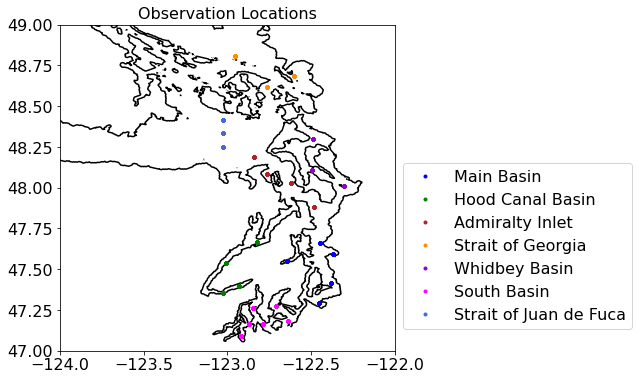

In [14]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [15]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'
seasons=[DJF,MAM,JJA,SON]

In [16]:
statsDict=dict()
statsDict['NO23']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict['NO23'][isub]=dict()
    var=statsDict['NO23'][isub]
    var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=displayStats(statsDict['NO23'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Admiralty Inlet
Main Basin
South Basin
Hood Canal Basin
Whidbey Basin
Strait of Georgia
Strait of Juan de Fuca


In [17]:
regions=['Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin','Strait of Georgia','Strait of Juan de Fuca']

### Model vs Observed comparisons by depth and region

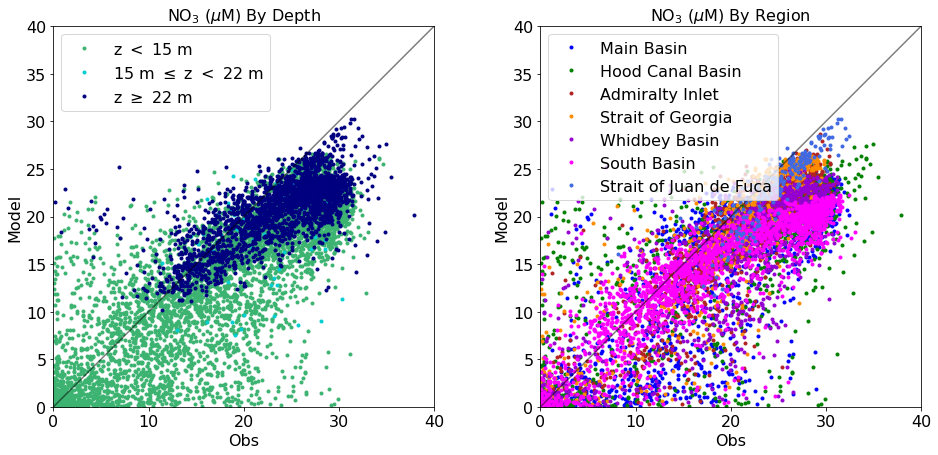

In [18]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'NO$_3$ ($\\mu$M)')

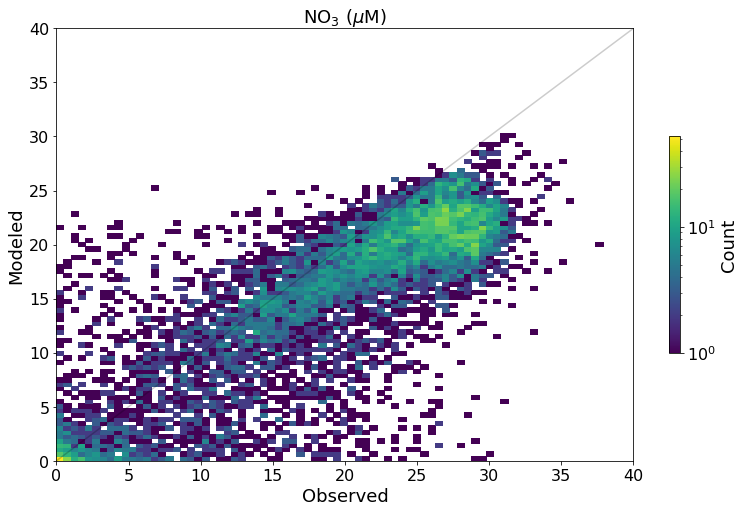

In [19]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('NO$_3$ ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

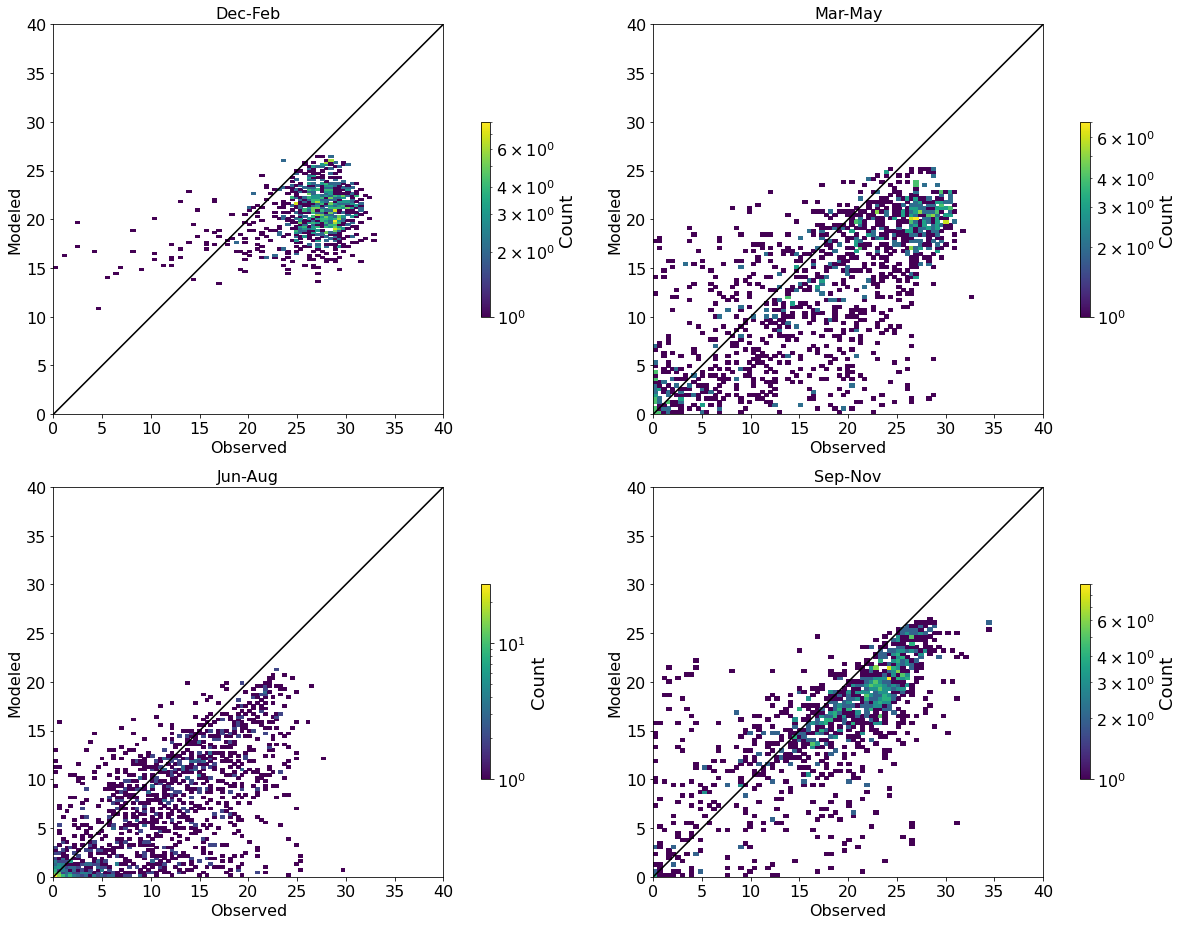

In [20]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(0,40))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions

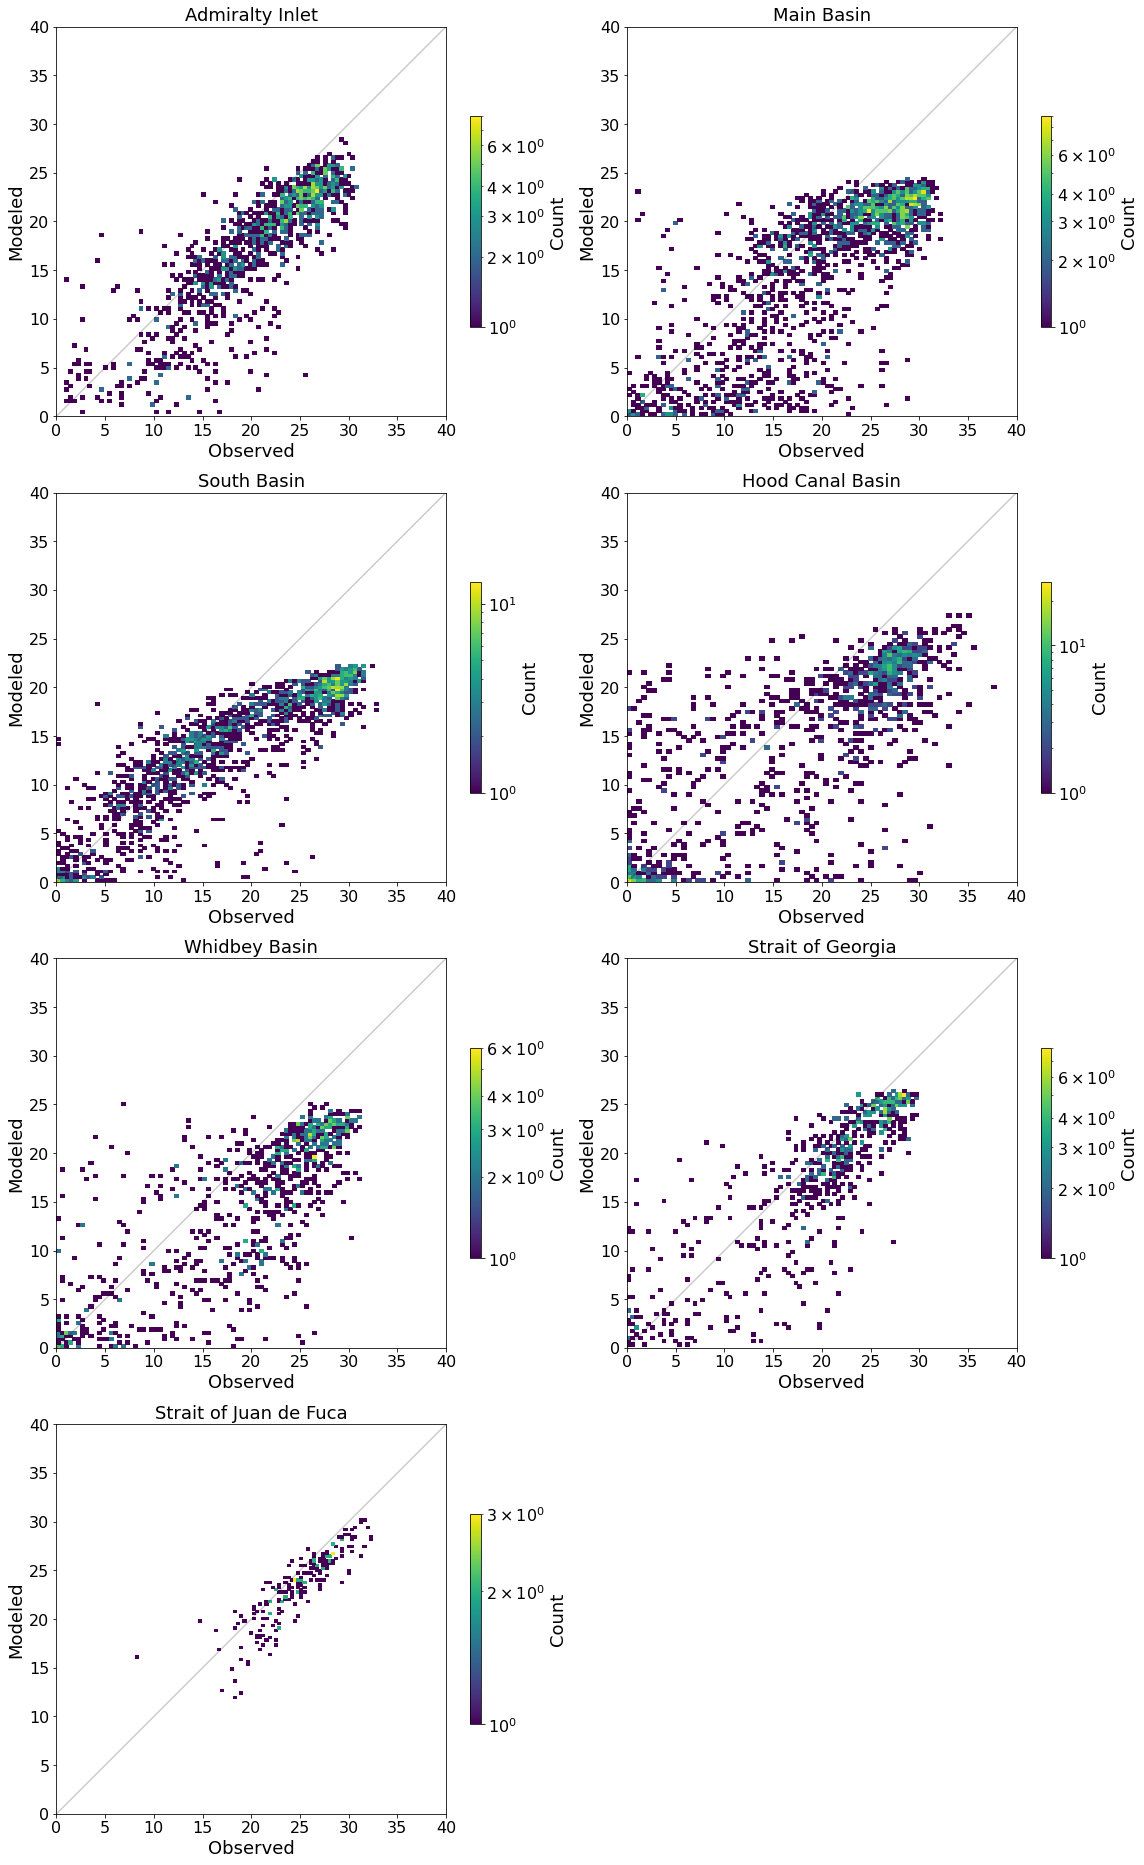

In [21]:
# Should alter to by region 2d histograms.
obsvar='NO23'
modvar='mod_nitrate'
lims=(0,40)
ax=ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims,fontsize=18)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [22]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'
seasons=[DJF,MAM,JJA,SON]

In [23]:
statsDict['dSi']=OrderedDict()
for isub in statsubs:
    statsDict['dSi'][isub]=dict()
    var=statsDict['dSi'][isub]
    var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=displayStats(statsDict['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

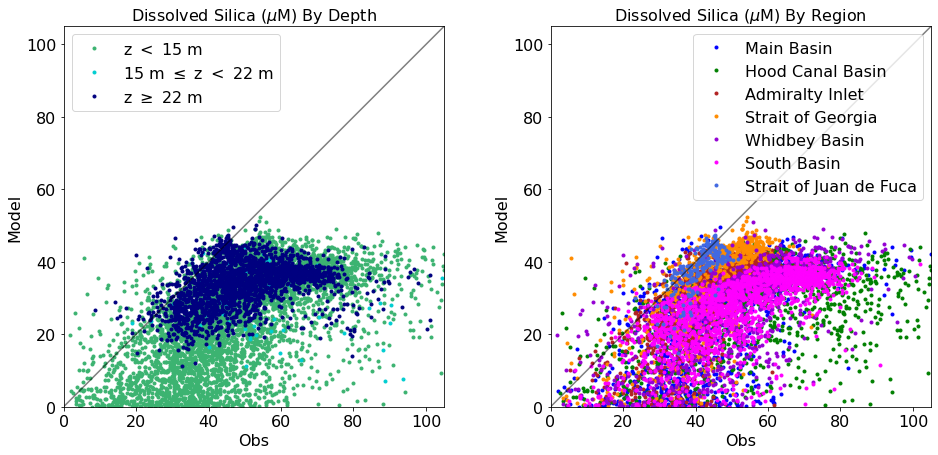

In [24]:
lims=(0,105)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'Si ($\\mu$M)')

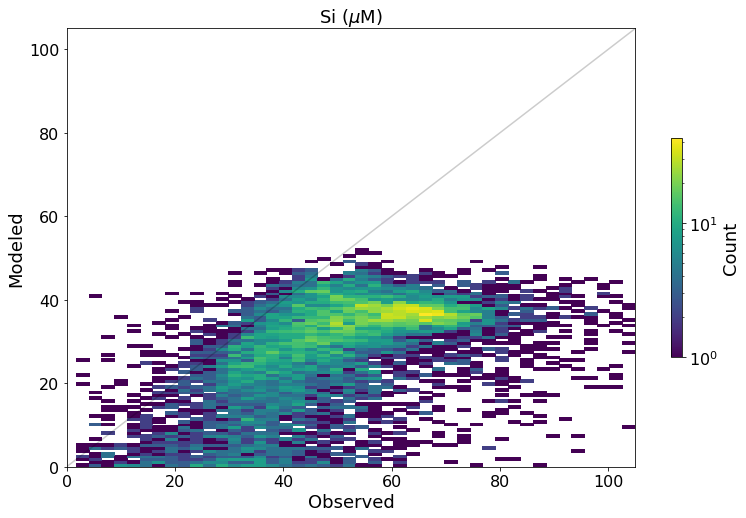

In [25]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,lims,fontsize=18)
ax.set_title('Si ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

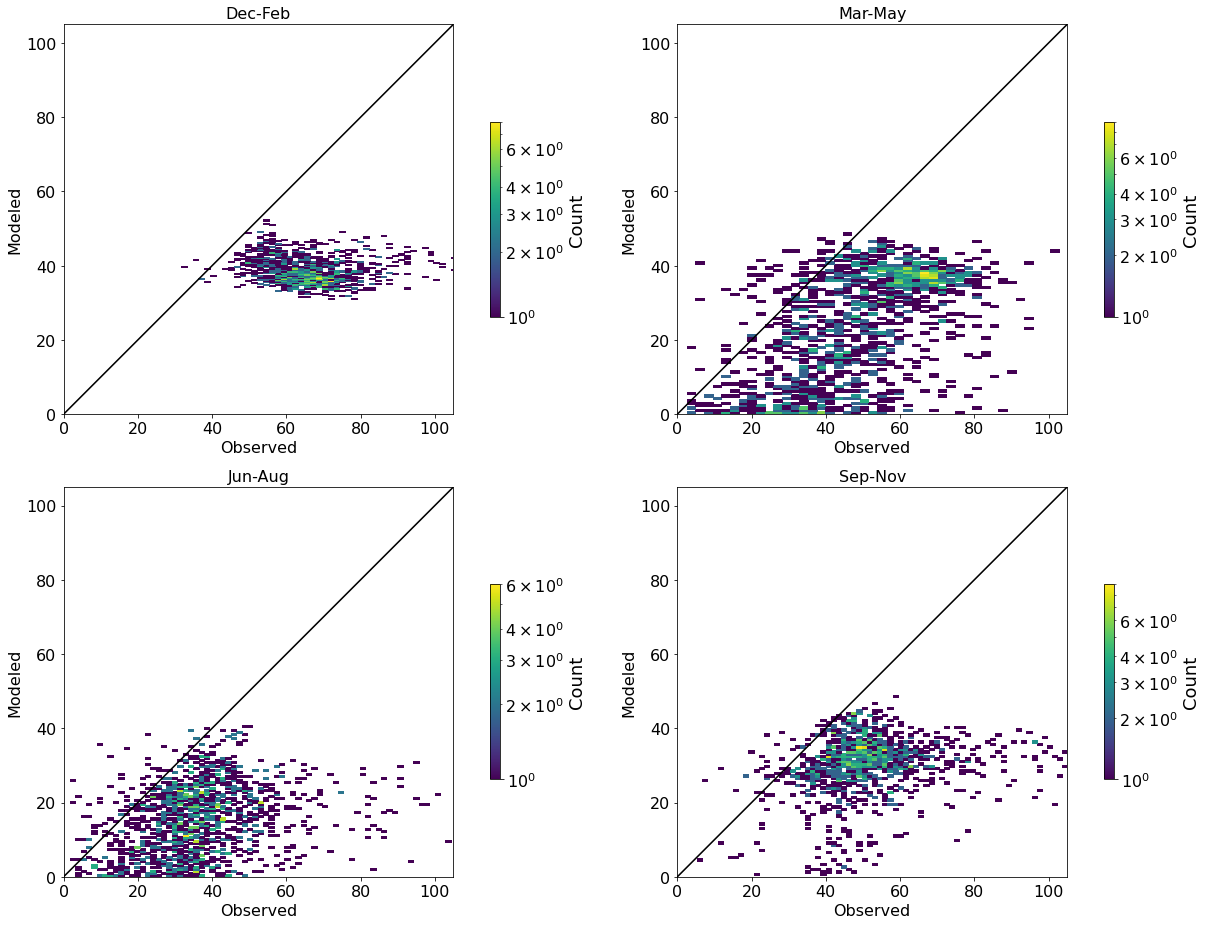

In [26]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions

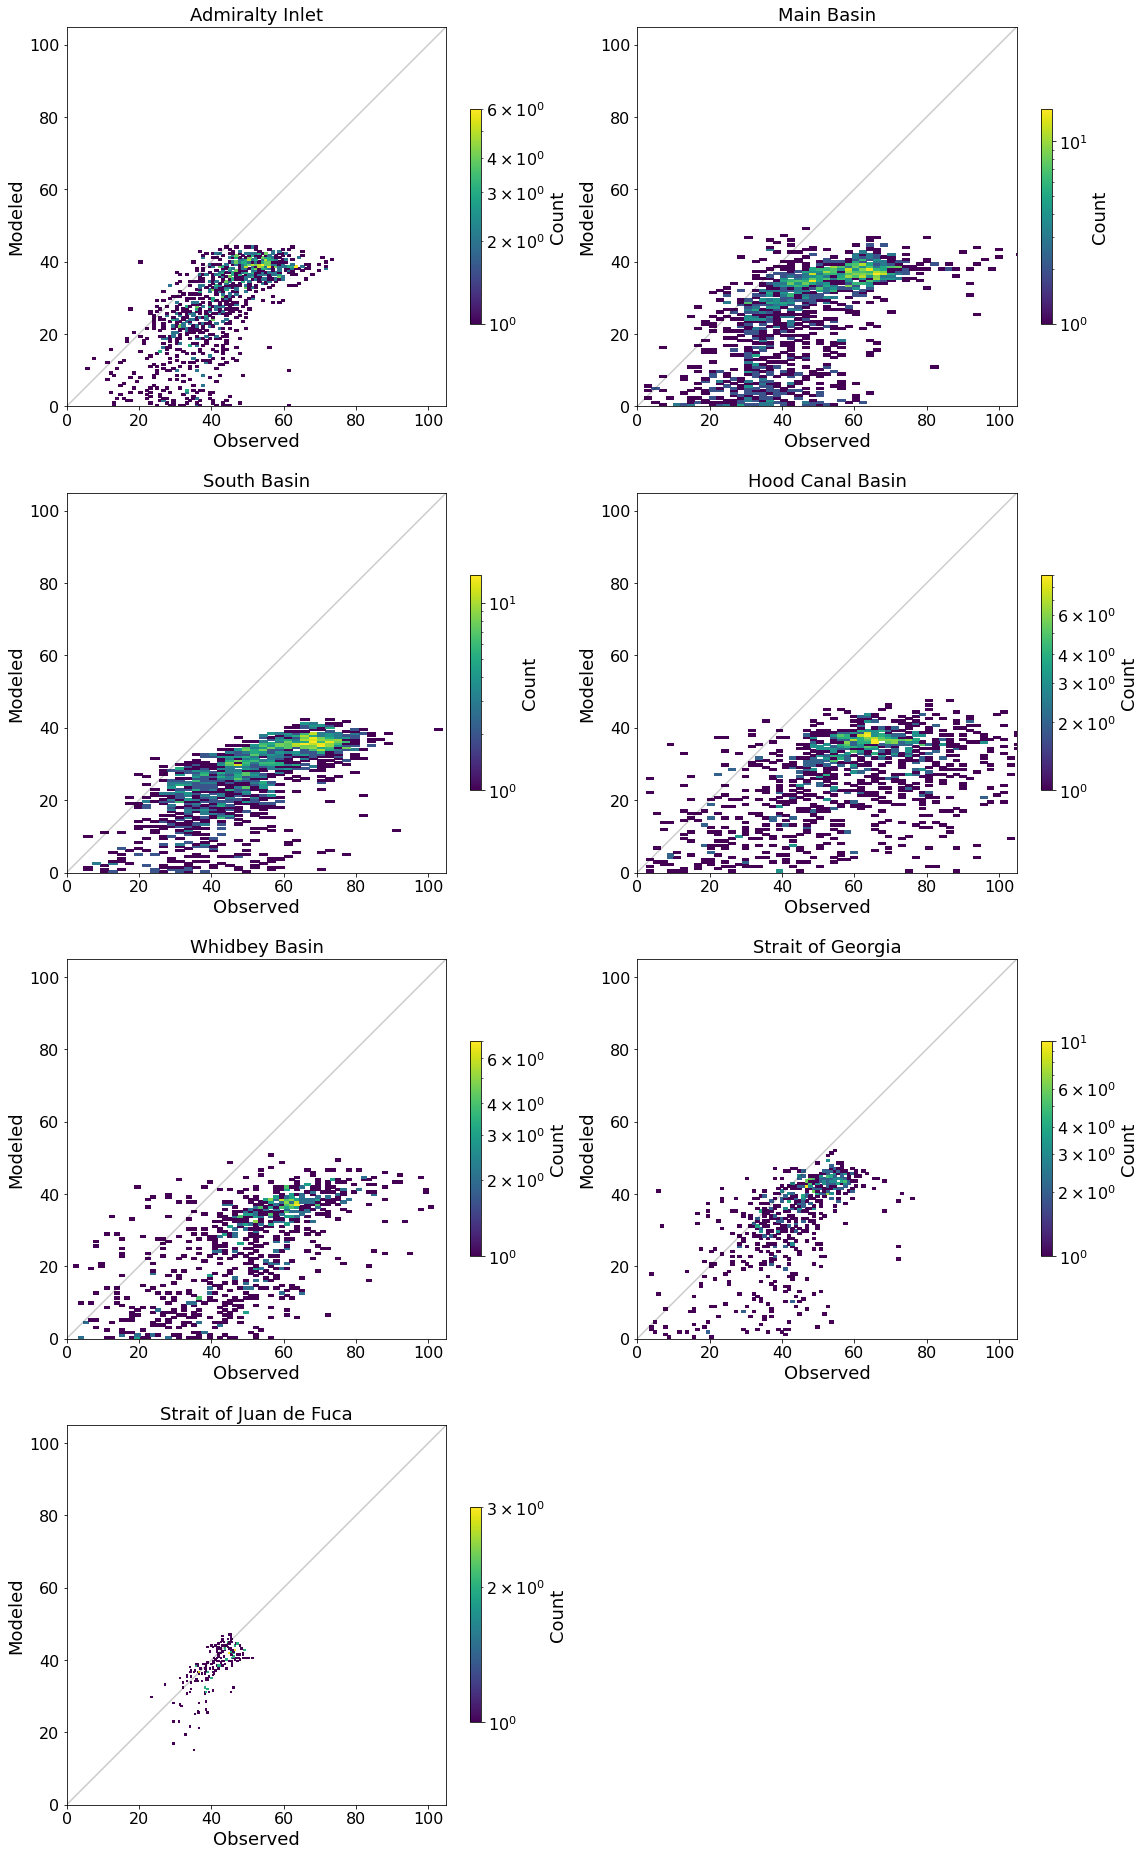

In [27]:
# Should alter to by region 2d histograms.
lims=(0,105)
ax=ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims,fontsize=18)

# dSi:NO3 Ratios

Check to make sure the other graph was not important. Change into histogram. Do plots for individual regions.

Text(546.5450965909091, 0.5, 'dSi ($\\mu$M)')

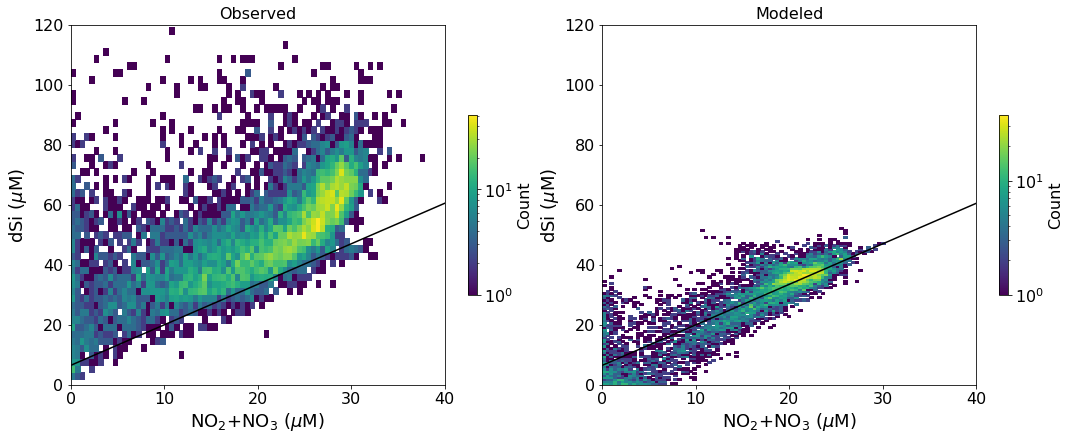

In [28]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
ratio_hist2d(ax[0],fig,data,'NO23','Si',(120,120))
ratio_hist2d(ax[1],fig,data,'mod_nitrate','mod_silicon',(120,120))
ax[0].set_title('Observed')
ax[0].set_xlabel('NO$_2$+NO$_3$ ($\mu$M)')
ax[0].set_ylabel('dSi ($\mu$M)')
ax[1].set_title('Modeled')
ax[1].set_xlabel('NO$_2$+NO$_3$ ($\mu$M)')
ax[1].set_ylabel('dSi ($\mu$M)')

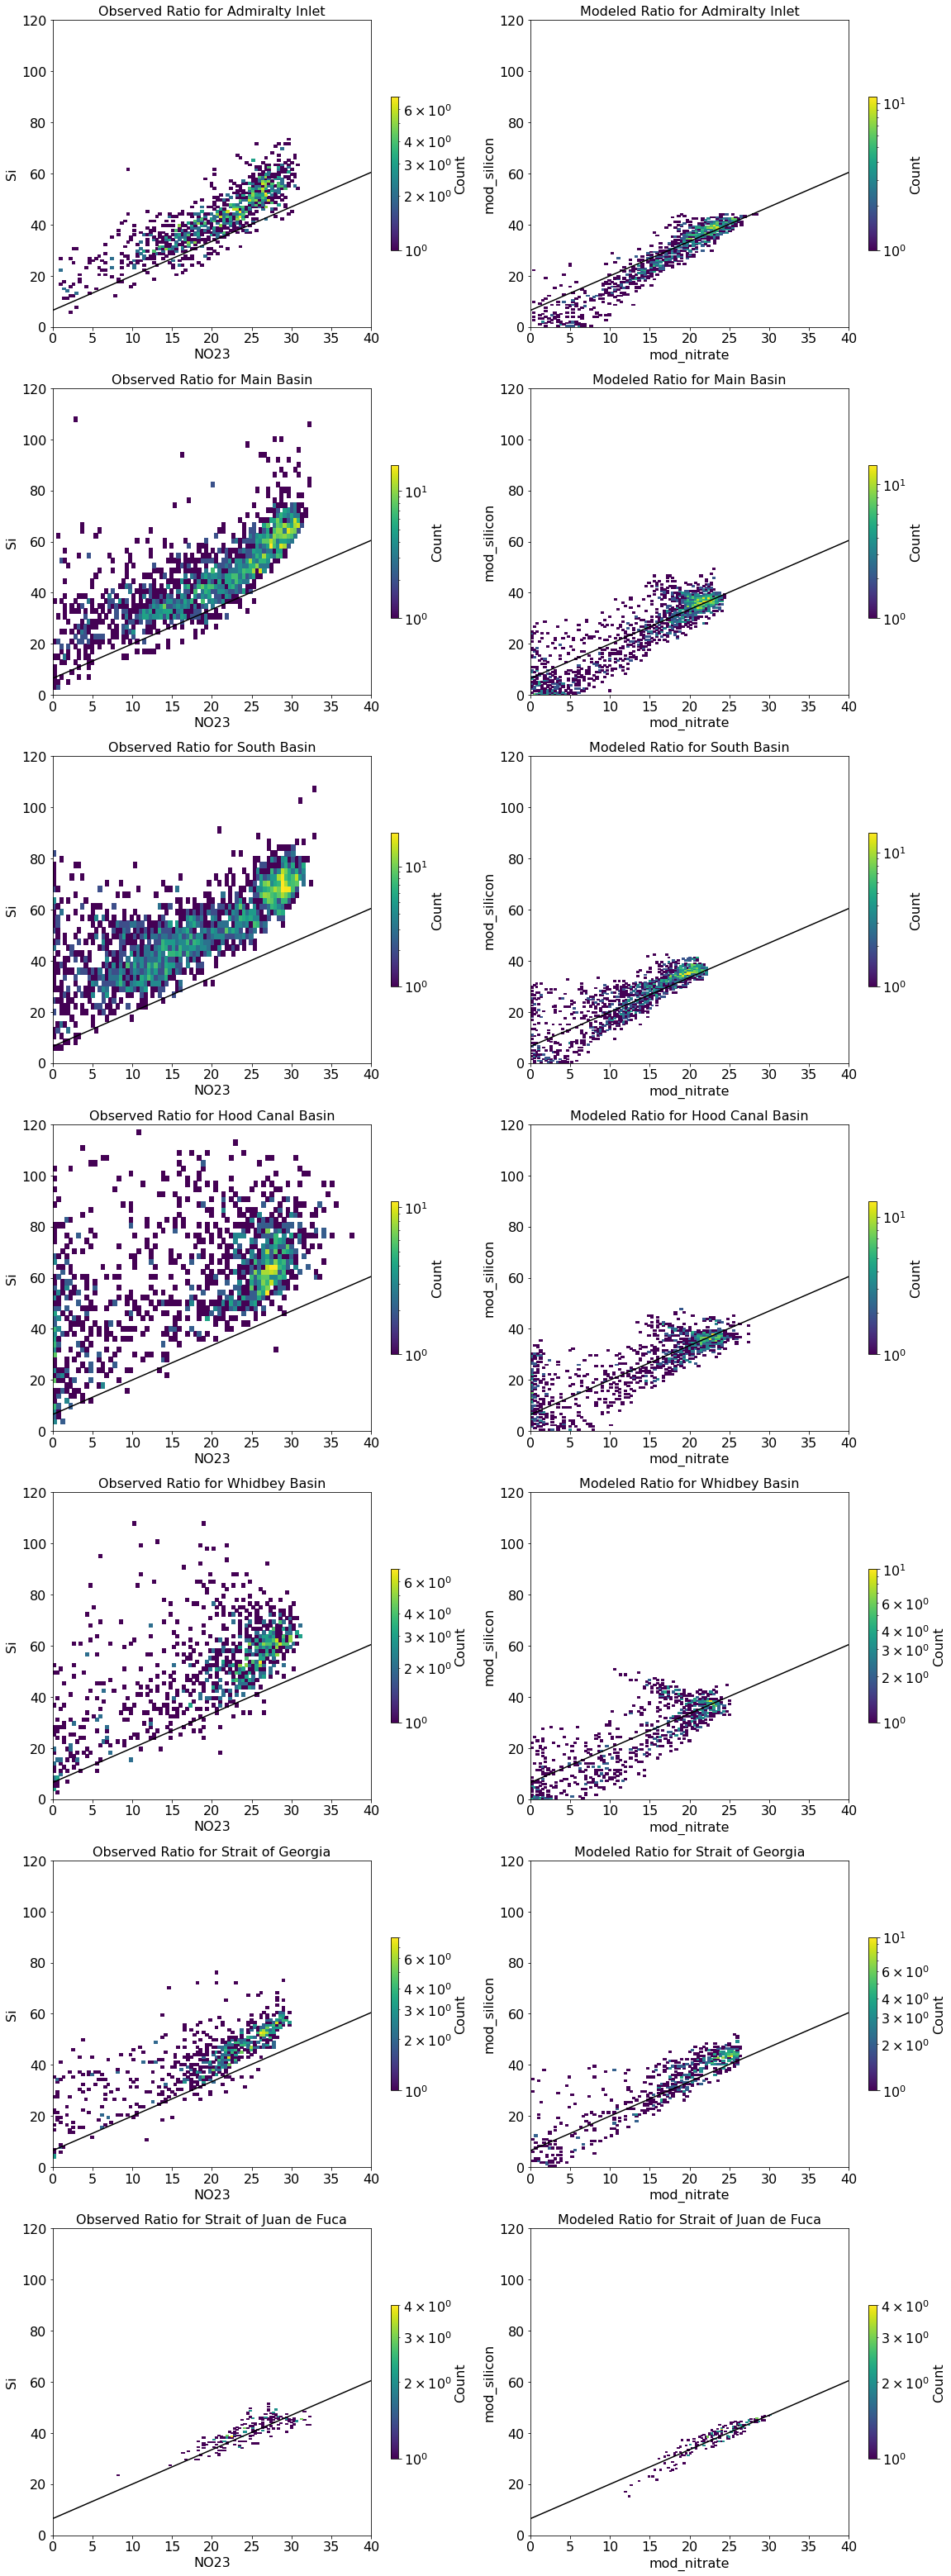

In [29]:
byRegion_ratio_hist2d(data,regions,'NO23','Si','mod_nitrate','mod_silicon',fontsize=16)

# NH4

### Table containing evaluation statistics for relevant subsets

In [30]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[DJF,MAM,JJA,SON]

In [31]:
statsDict['NH4']=OrderedDict()
for isub in statsubs:
    statsDict['NH4'][isub]=dict()
    var=statsDict['NH4'][isub]
    var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=displayStats(statsDict['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

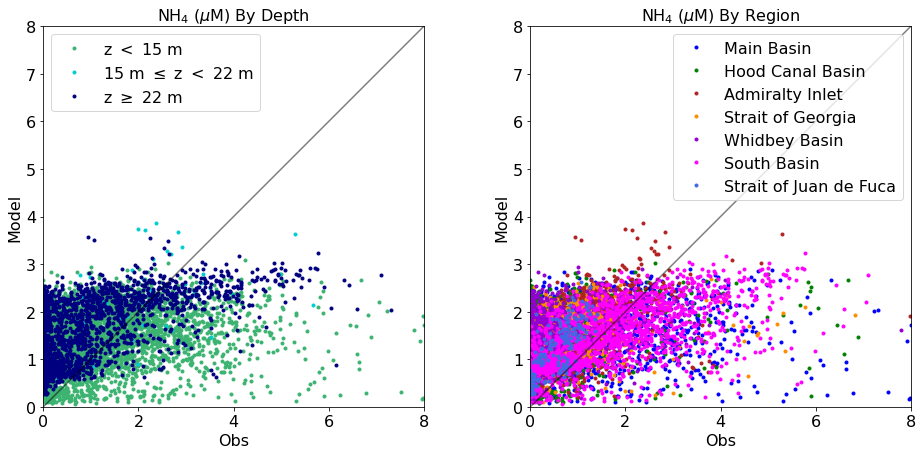

In [32]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
lims=(0,8)
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'NH$_4$ ($\\mu$M)')

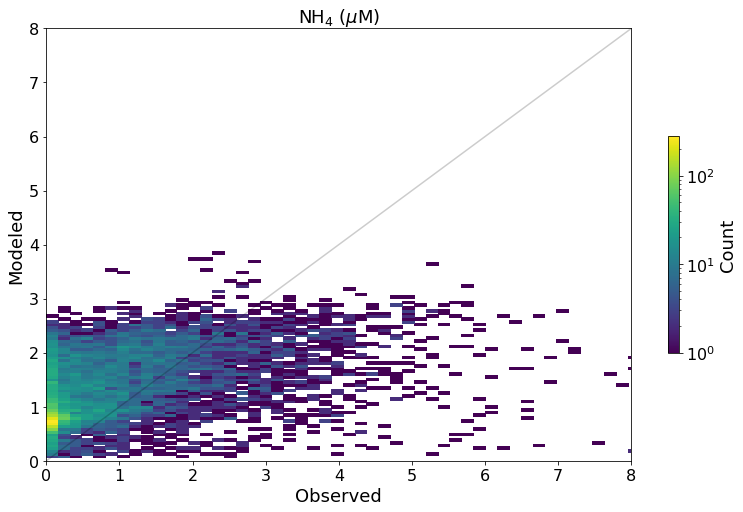

In [33]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,lims,fontsize=18)
ax.set_title('NH$_4$ ($\mu$M)',fontsize=18)

### Model vs Observed comparisons for individual seasons

In [34]:
def hist2d(ax,fig,df,obsvar,modvar,lims,fontsize=12,cbticks=[]):
    ax.plot(lims,lims,'k-',alpha=.2)
    ii=(~np.isnan(df[obsvar]))&(~np.isnan(df[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[obsvar]].values.flatten(),
                                      df.loc[ii,[modvar]].values.flatten(),bins=25*3,
                                         norm=LogNorm(1,20))
    cb=fig.colorbar(ps,ax=ax,shrink=0.7)
    if len(cbticks) != 0:
        cb.set_ticks(cbticks)
    cb.set_label(label='Count',size=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps  

In [35]:
def bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(ax[0][0],fig,seasons[0],obsvar,modvar,lims,fontsize=17)
    ax[0][0].set_title(season_titles[0],fontsize=18)
    jp=hist2d(ax[0][1],fig,seasons[1],obsvar,modvar,lims,fontsize=17)
    ax[0][1].set_title(season_titles[1],fontsize=18)
    jp=hist2d(ax[1][0],fig,seasons[2],obsvar,modvar,lims,fontsize=17)
    ax[1][0].set_title(season_titles[2],fontsize=18)
    jp=hist2d(ax[1][1],fig,seasons[3],obsvar,modvar,lims,fontsize=17)
    ax[1][1].set_title(season_titles[3],fontsize=18)
    return

Text(0.5, 1.0, 'hghgh')

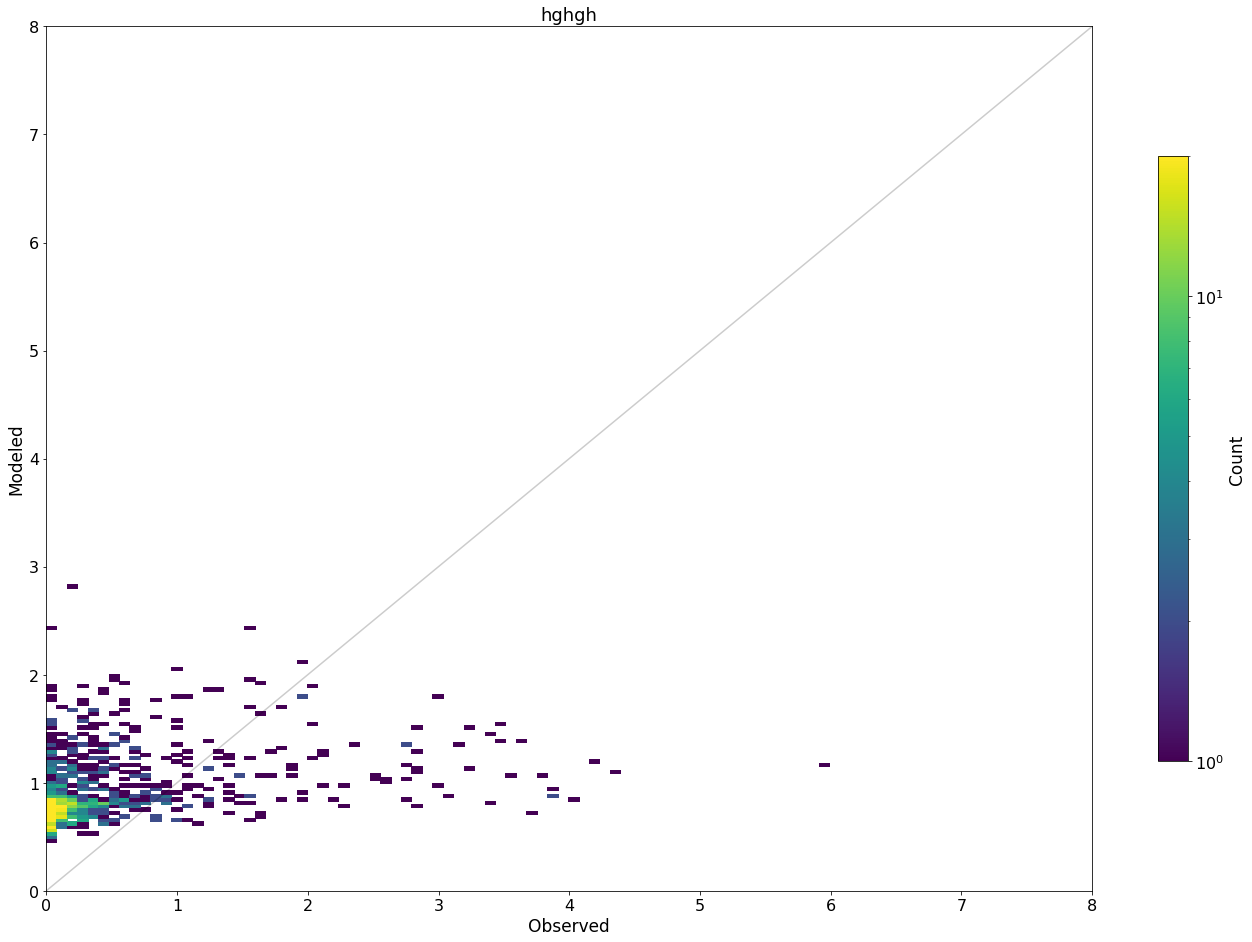

In [36]:
fig, ax = plt.subplots(1,1,figsize = (19,13))
jp=hist2d(ax,fig,seasons[0],obsvar,modvar,lims,fontsize=17)
ax.set_title('hghgh',fontsize=18)

Text(790.2811547009943, 0.5, '')

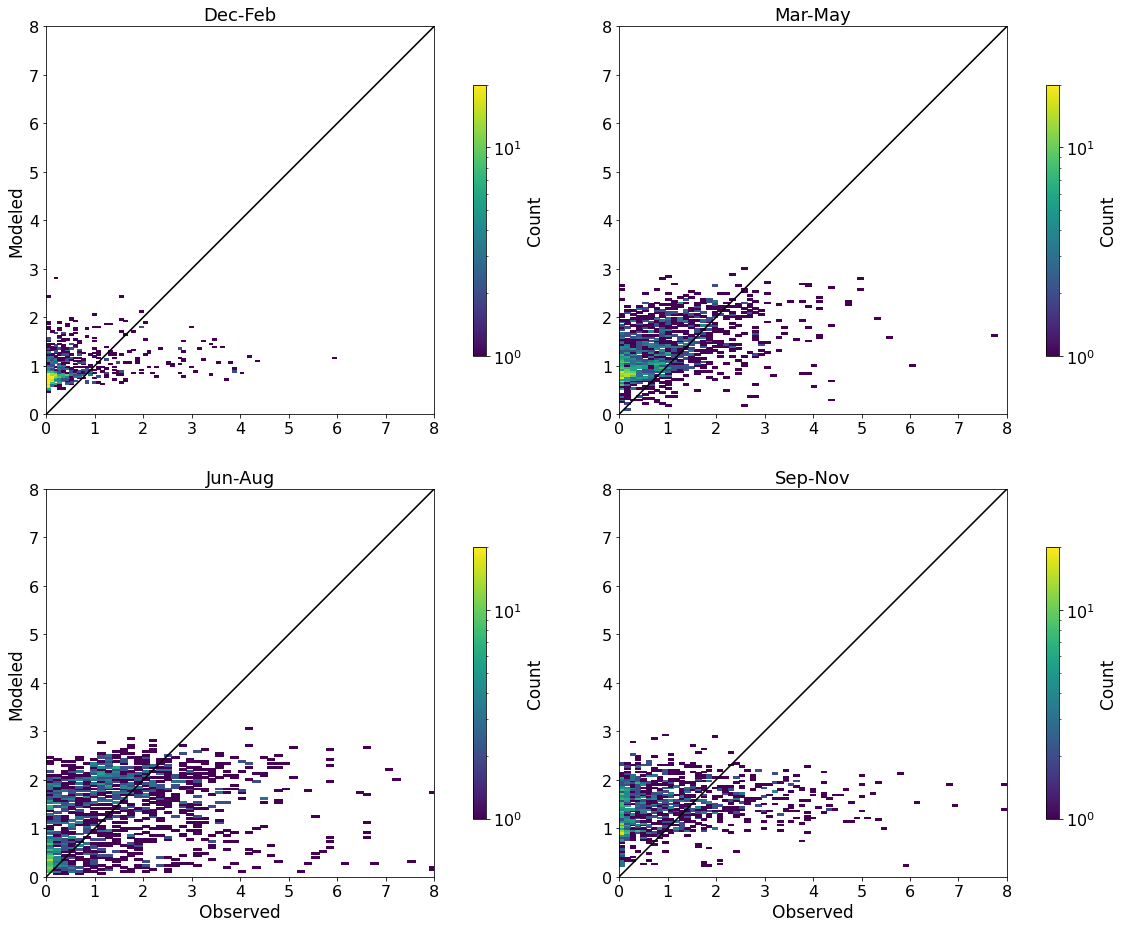

In [37]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims)
ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('')
ax[1][1].set_ylabel('')

### Model vs Observed comparisons for individual regions and stations

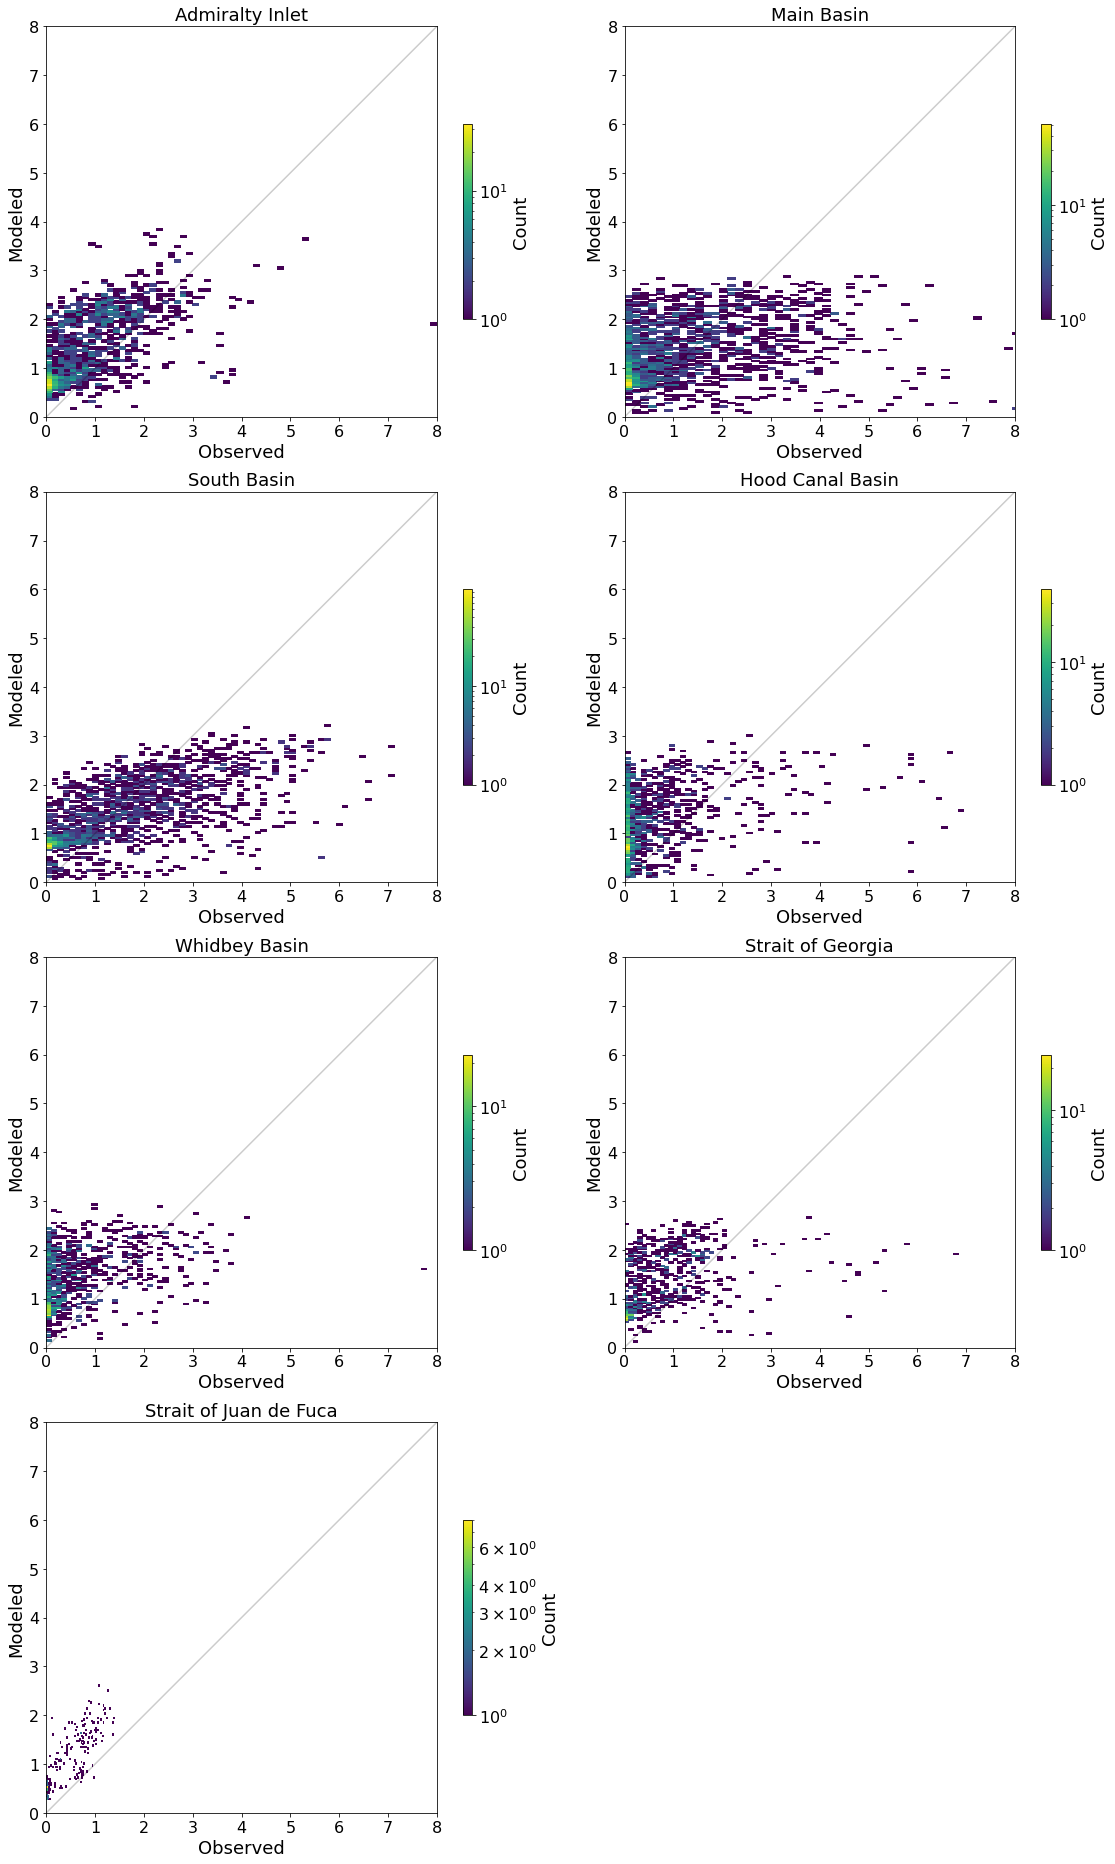

In [38]:
# Should alter to by region 2d histograms.
ax=ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims,fontsize=18)

## Summary Table of Evaluation Statistics

In [39]:
tbl,tdf=displayStats(statsDict,level='Variable',suborder=list(statsubs.keys()))
tbl

# Model Error vs Observed Environmental Variables

In [40]:
### These groupings will be used to calculate correlation statistics. The keys are labels and
### the values are corresponding dataframe views
errsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                     'z > 22 m':data.loc[data.Z>22],
                     'all':data,})

### An empty nested dictionary which the correlation statistics will be organized into.
ErrDict={'CT':dict(),
        'SA':dict(),
        'Lat':dict()}

In [41]:
errsubs['z < 15 m'].query('CT < 16 & CT > 4').loc[:, 'CT']

0        8.715218
1        9.311250
2        9.319583
3        9.577859
4        7.287697
          ...    
8565    10.215181
8568    10.303085
8569     9.991542
8570     9.989054
8571    10.341087
Name: CT, Length: 5363, dtype: float64

## Error vs temperature

### Table containing evaluation statistics for relevant subsets

In [42]:
envvar='CT'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']= ket.err_corr_stats(errsubs[isub].query('CT < 16 & CT > 4').loc[:,[envvar]],
                                                        errsubs[isub].query('CT < 16 & CT > 4').loc[:,[obsvar]], 
                                                        errsubs[isub].query('CT < 16 & CT > 4').loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs temperature for different depths

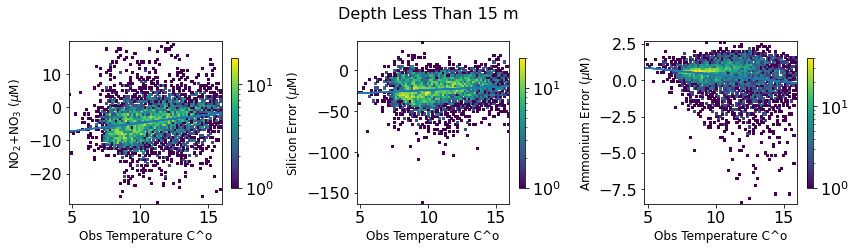

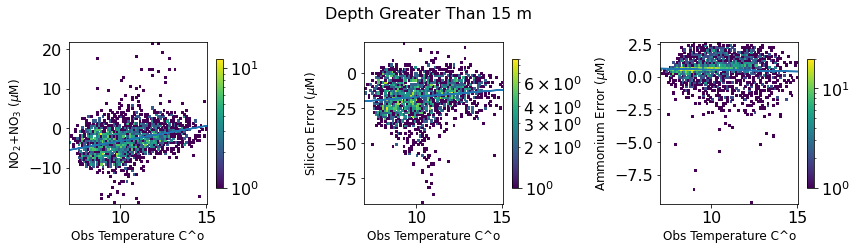

In [43]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[(data.Z <15)&(data.CT >4)&(data.CT < 16)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z <15)&(data.CT >4)&(data.CT < 16)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth Less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[(data.Z >15)&(data.CT >4)&(data.CT < 16)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z >15)&(data.CT >4)&(data.CT < 16)],modvar,obsvar,envvar)


ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth Greater Than 15 m')
plt.tight_layout()

## Error vs salinity

### Table containing evaluation statistics for relevant subsets

In [44]:
envvar='SA'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']=ket.err_corr_stats(errsubs[isub].query('SA < 33 & SA > 26').loc[:,[envvar]],
                                                        errsubs[isub].query('SA < 33 & SA > 26').loc[:,[obsvar]],
                                                        errsubs[isub].query('SA < 33 & SA > 26').loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs salinity for different depths

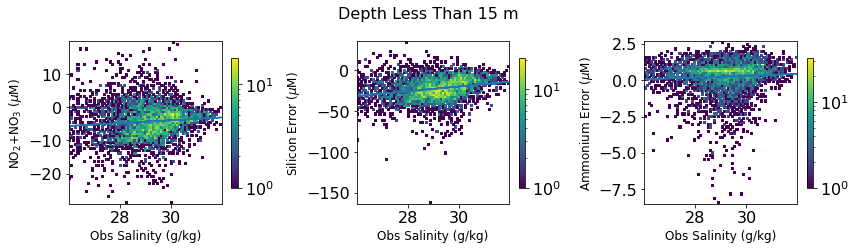

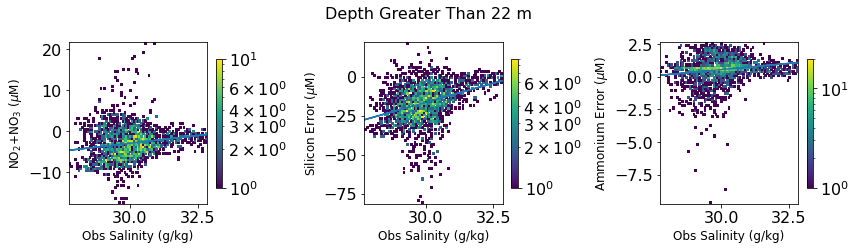

In [45]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[(data.Z <15)&(data.SA >26)&(data.SA < 33)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z <15)&(data.SA >26)&(data.SA < 33)],modvar,obsvar,envvar)


ax[0].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)

fig.suptitle('Depth Less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[(data.Z >22)&(data.SA >26)&(data.SA < 33)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z >22)&(data.SA >26)&(data.SA < 33)],modvar,obsvar,envvar)


ax[0].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)

fig.suptitle('Depth Greater Than 22 m')
plt.tight_layout()

## Error vs lat

### Table containing evaluation statistics for relevant subsets

In [46]:
envvar='Lat'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']=ket.err_corr_stats(errsubs[isub].loc[:,[envvar]],
                                                        errsubs[isub].loc[:,[obsvar]],
                                                        errsubs[isub].loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs latitude for different depths

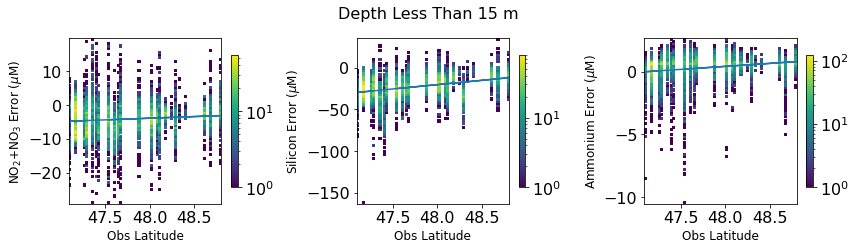

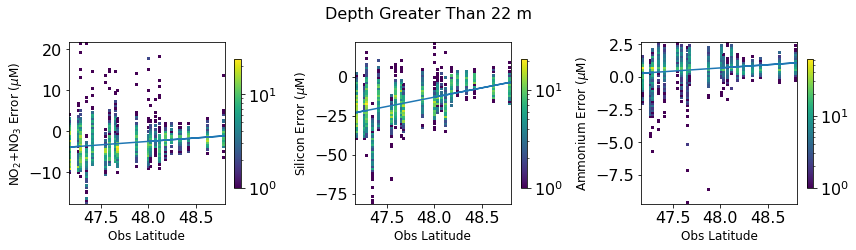

In [47]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[data.Z <15],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[data.Z <15],modvar,obsvar,envvar)


ax[0].set_xlabel('Obs Latitude',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Latitude',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Latitude',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)

fig.suptitle('Depth Less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    hist2d_err(ax[ind],fig,data[data.Z >22],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[data.Z >22],modvar,obsvar,envvar)


ax[0].set_xlabel('Obs Latitude',fontsize=12)
ax[0].set_ylabel('NO$_2$+NO$_3$ Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Latitude',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Latitude',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)

fig.suptitle('Depth Greater Than 22 m')
plt.tight_layout()

## Summary Table of Correlation Statistics

In [48]:
tbl,tdf=ket.Display_CorrStats(ErrDict,level='Environmental Variable')
tbl

## Model Error vs Salinity Error

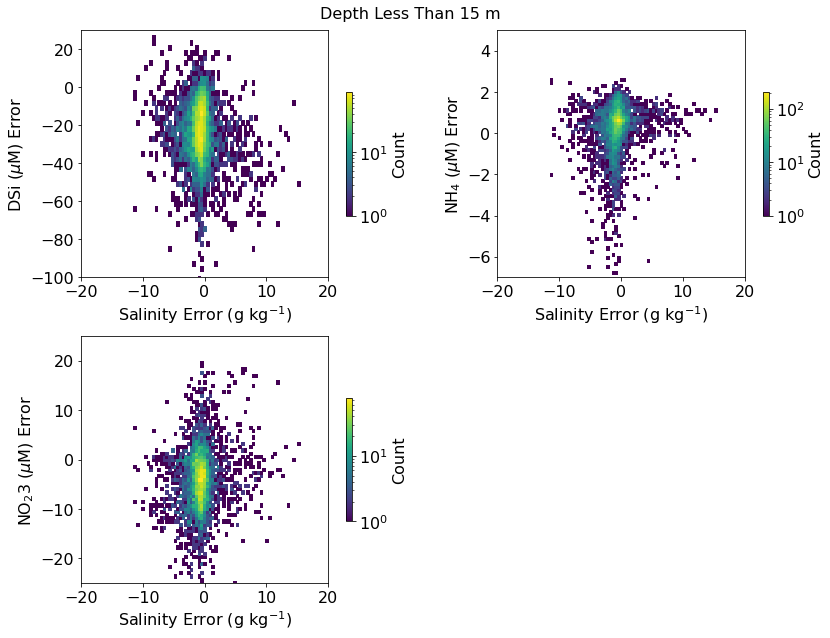

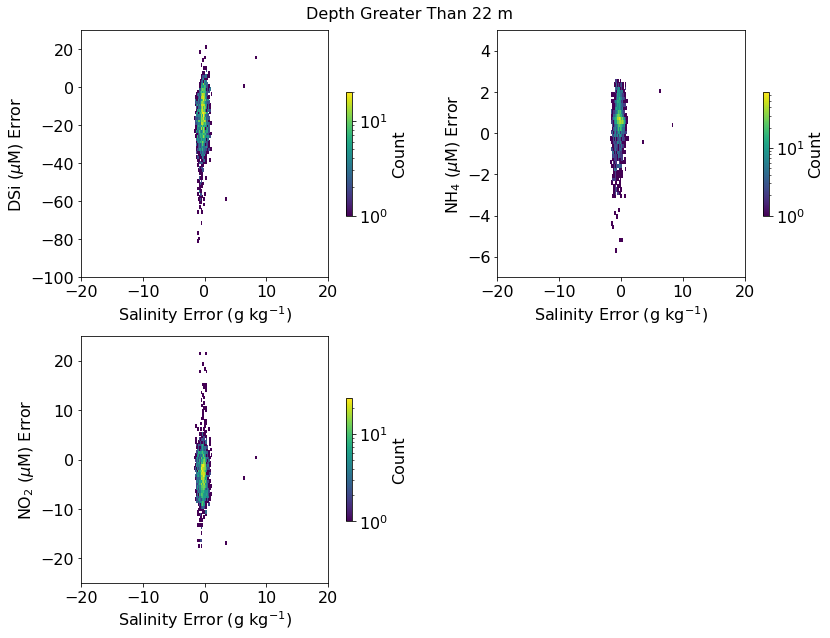

In [49]:
less_15=data[data.Z < 15]
great_22=data[data.Z > 22]

fig,ax=plt.subplots(2,2,figsize=(12,9))
ax[0][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][0].set_ylabel('DSi ($\mu$M) Error')
cb=ErrErr_hist2d(less_15,fig,ax[0][0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-100,30))
ax[0][1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][1].set_ylabel('NH$_4$ ($\mu$M) Error')
cb=ErrErr_hist2d(less_15,fig,ax[0][1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-7,5))
ax[1][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1][0].set_ylabel('NO$_23$ ($\mu$M) Error')
cb=ErrErr_hist2d(less_15,fig,ax[1][0],'SA','mod_vosaline','NO23','mod_nitrate',(-20,20),(-25,25))
fig.delaxes(ax[-1][-1])
fig.suptitle('Depth Less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(2,2,figsize=(12,9))
ax[0][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][0].set_ylabel('DSi ($\mu$M) Error')
cb=ErrErr_hist2d(great_22,fig,ax[0][0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-100,30))
ax[0][1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][1].set_ylabel('NH$_4$ ($\mu$M) Error')
cb=ErrErr_hist2d(great_22,fig,ax[0][1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-7,5))
ax[1][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1][0].set_ylabel('NO$_2$ ($\mu$M) Error')
cb=ErrErr_hist2d(great_22,fig,ax[1][0],'SA','mod_vosaline','NO23','mod_nitrate',(-20,20),(-25,25))
fig.delaxes(ax[-1][-1])
fig.suptitle('Depth Greater Than 22 m')
plt.tight_layout()

# Salinity

### Table containing evaluation statistics for relevant subsets

In [50]:
# Defining Variables for determining Ammonium
obsvar='SA'
modvar='mod_vosaline'
seasons=[DJF,MAM,JJA,SON]

In [51]:
statsDict['SA']=OrderedDict()
for isub in statsubs:
    statsDict['SA'][isub]=dict()
    var=statsDict['SA'][isub]
    var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=displayStats(statsDict['SA'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

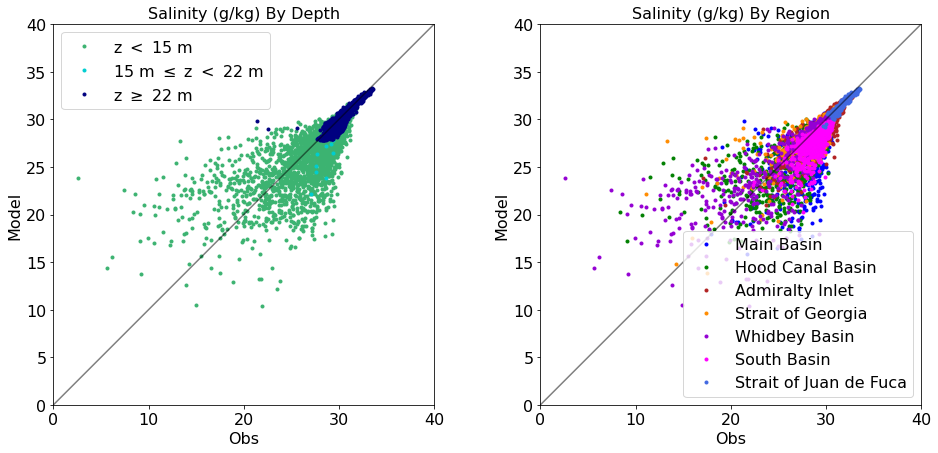

In [52]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
lims=(0,40)
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Salinity (g/kg) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Salinity (g/kg) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'Salinity (g/kg)')

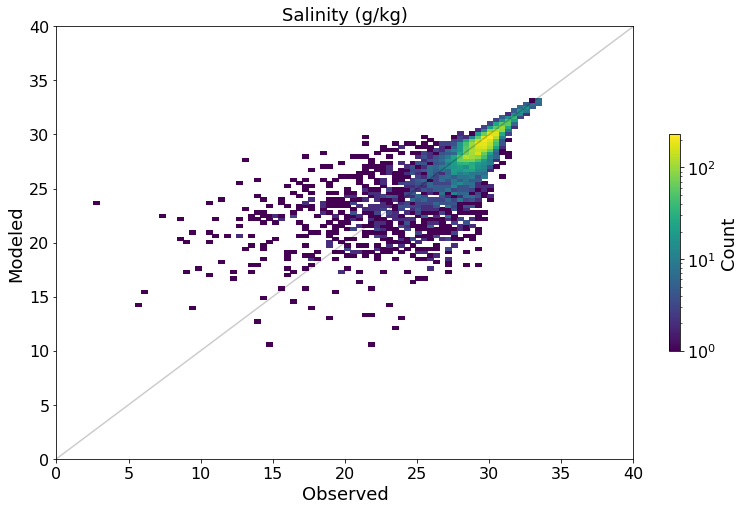

In [53]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,lims,fontsize=18)
ax.set_title('Salinity (g/kg)',fontsize=18)

### Model vs Observed comparisons for individual seasons

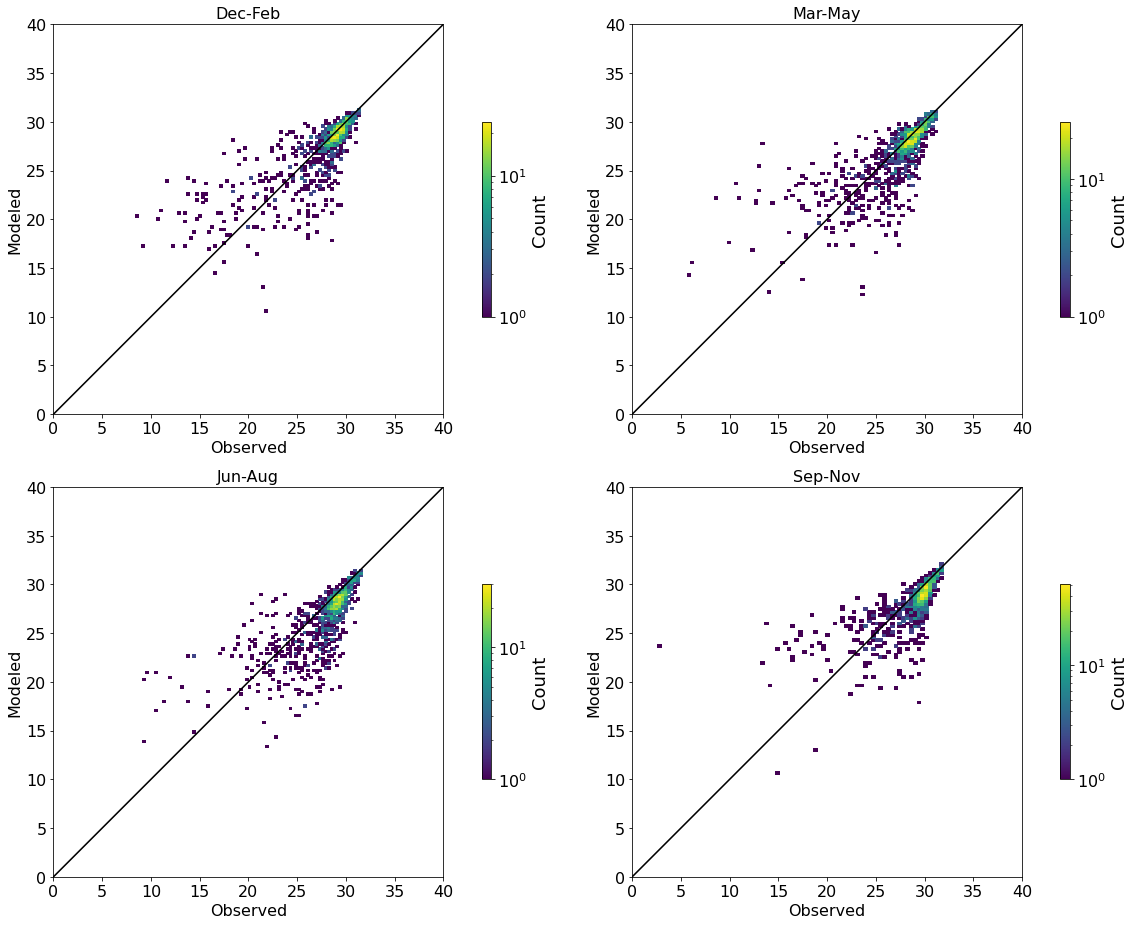

In [54]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions and stations

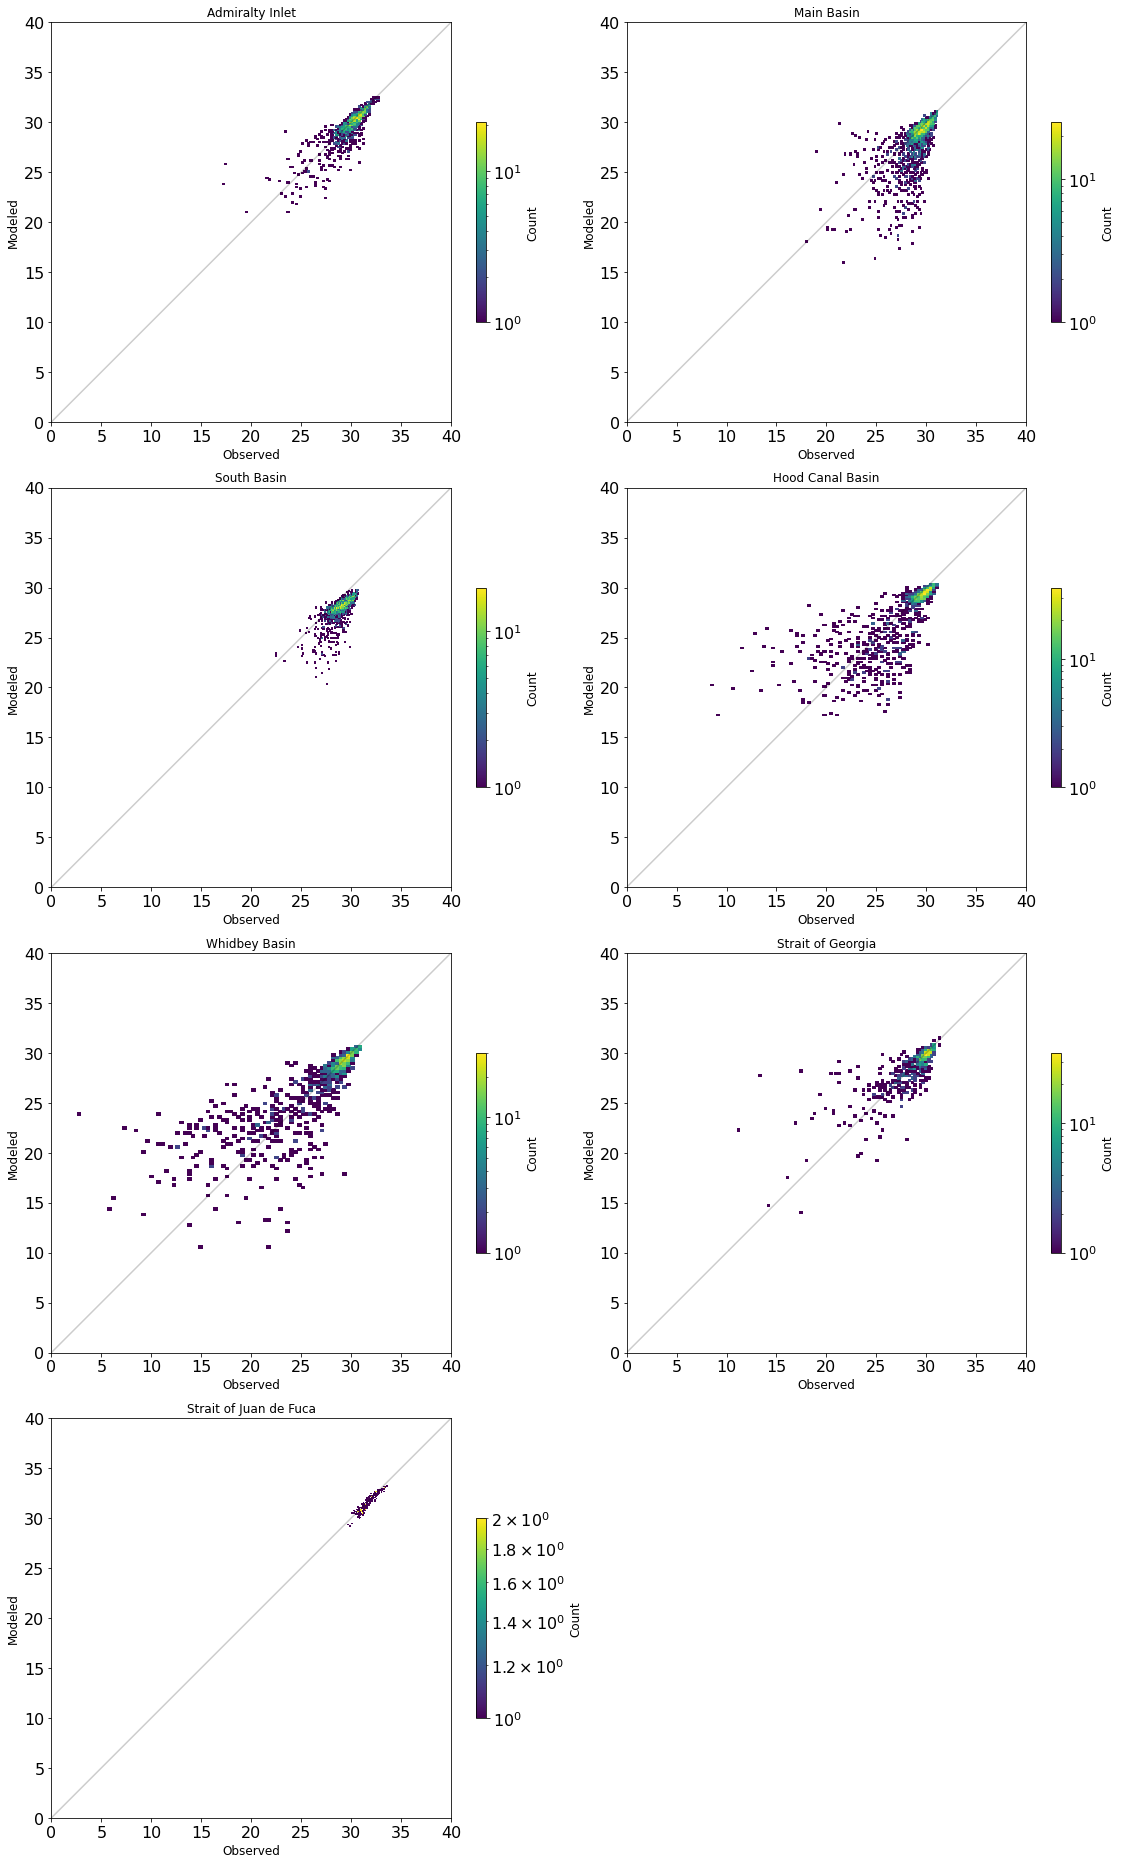

In [55]:
# Should alter to by region 2d histograms.
ax=ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims)

# Temperature

### Table containing evaluation statistics for relevant subsets

In [56]:
# Defining Variables for determining Ammonium
obsvar='CT'
modvar='mod_votemper'
seasons=[DJF,MAM,JJA,SON]

In [57]:
statsDict['CT']=OrderedDict()
for isub in statsubs:
    statsDict['CT'][isub]=dict()
    var=statsDict['CT'][isub]
    var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=displayStats(statsDict['CT'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

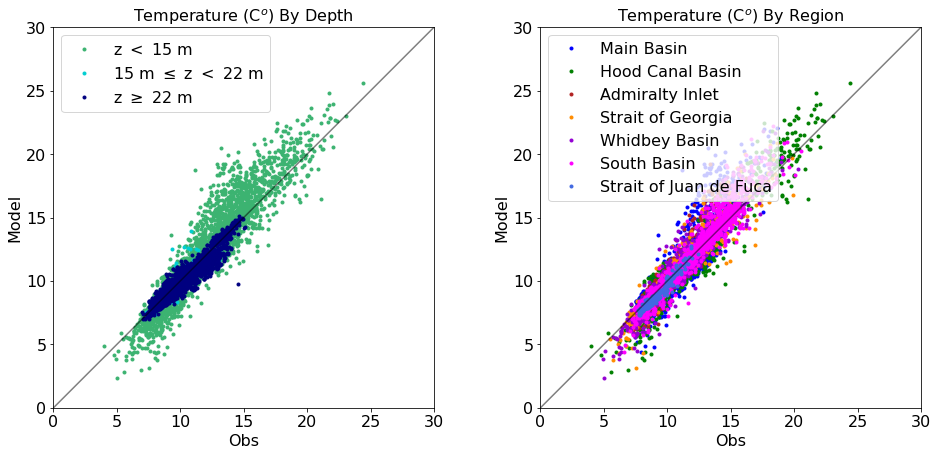

In [58]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
lims=(0,30)
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Temperature (C$^o$) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Temperature (C$^o$) By Region');

## 2D histogram of modeled vs observed data

Text(0.5, 1.0, 'Temperature (C$^o$)')

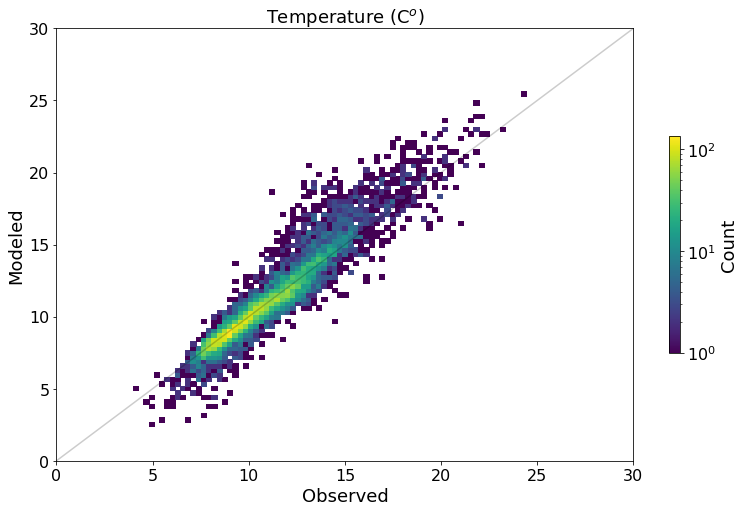

In [59]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data,obsvar,modvar,lims,fontsize=18)
ax.set_title('Temperature (C$^o$)',fontsize=18)

### Model vs Observed comparisons for individual seasons

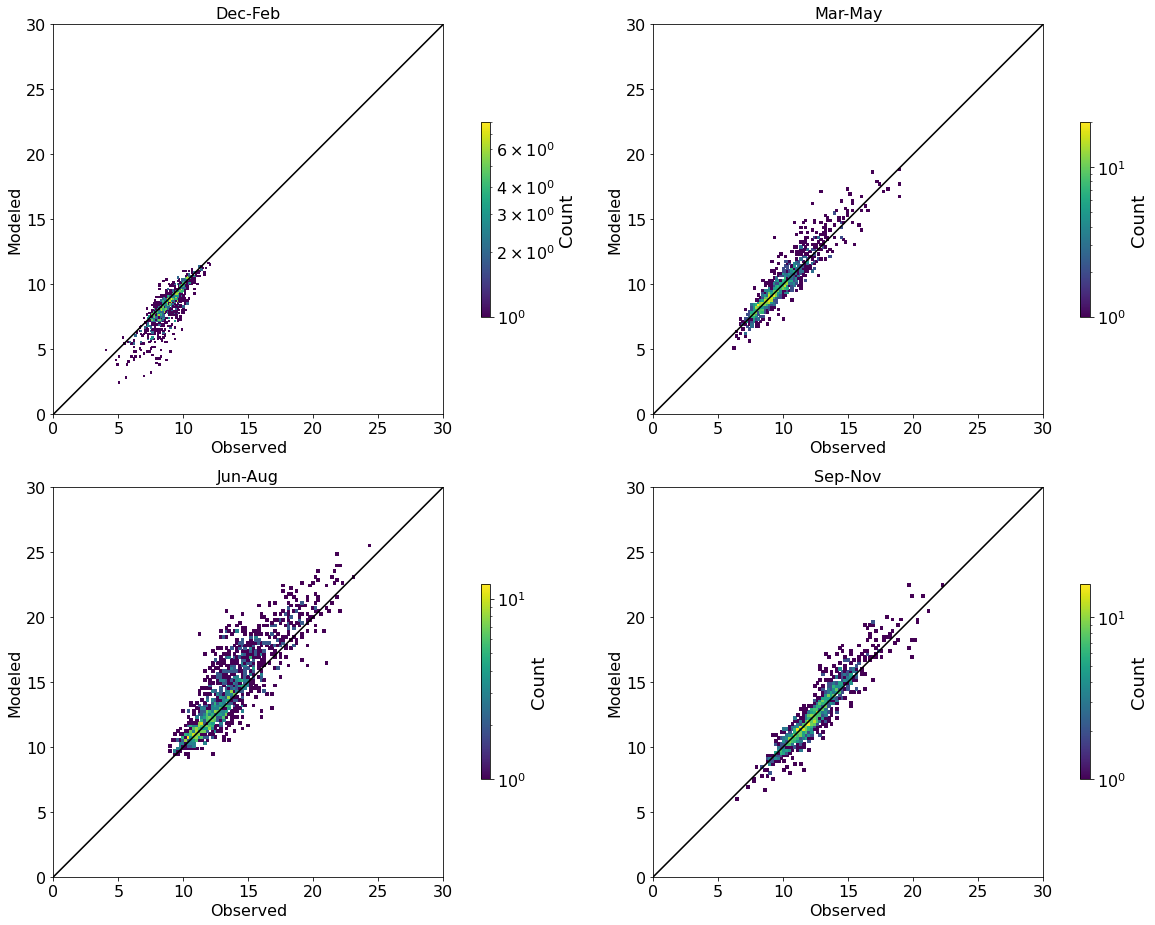

In [60]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Model vs Observed comparisons for individual regions and stations

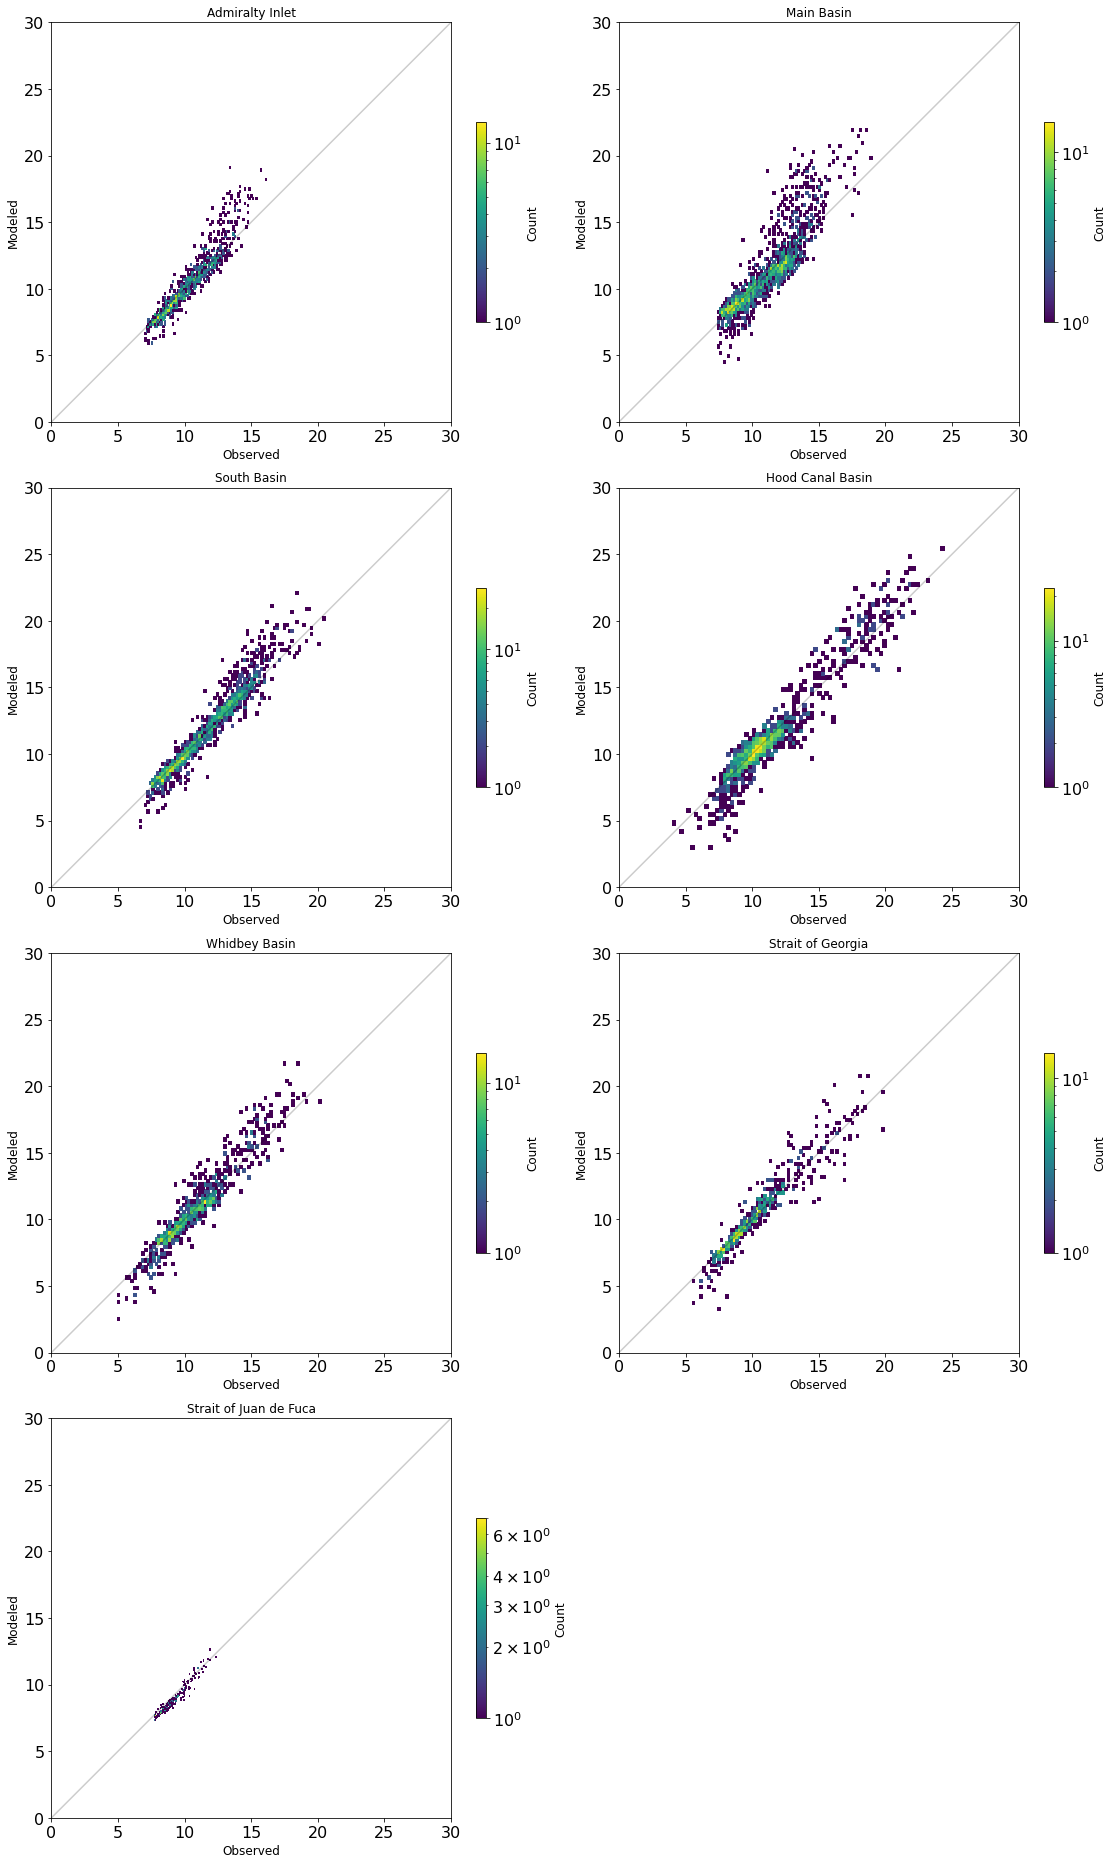

In [61]:
# Should alter to by region 2d histograms.
ax=ket.byRegion_hist2d(datreg,regions,obsvar,modvar,lims)

## Experimenting with creating a table that summarizes the evaluation statistics for each year.

In [62]:
obsvar_list=['NO23','Si','Amm']
modvar_list=['mod_nitrate','mod_silicon','mod_ammonium']
yearstats=dict()
for obsvar,modvar in zip(obsvar_list,modvar_list):
    yearstats[obsvar]=OrderedDict()
    for isub in yearsubs:
        yearstats[obsvar][isub]=dict()
        var=yearstats[obsvar][isub]
        var['N'],var['mmean'],omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(yearsubs[isub].loc[:,[obsvar]],
                                                                             yearsubs[isub].loc[:,[modvar]])
    

In [63]:
tbl,tdf=displayStats(yearstats,level='Variable',suborder=list(yearsubs.keys()))
tbl

Text(0.5, 1.0, 'NH$_4$ ($\\mu$M)')

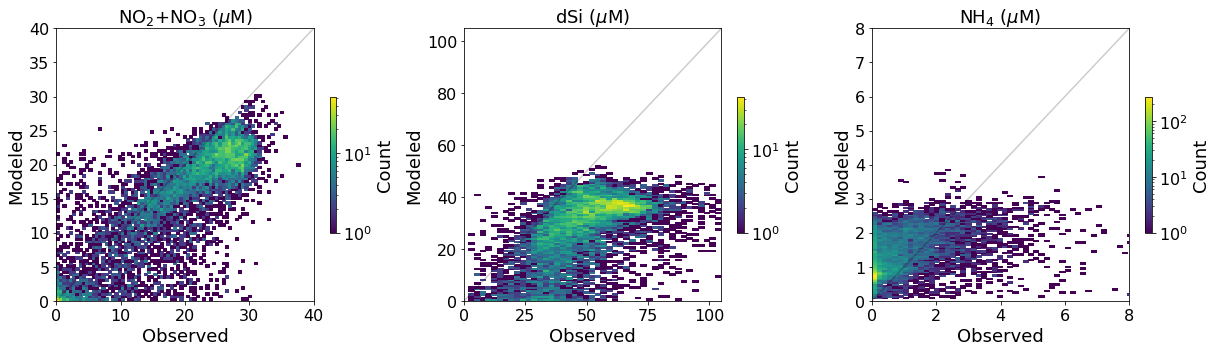

In [64]:
fig, ax = plt.subplots(1,3,figsize= (17,5))
ps = ket.hist2d(ax[0],fig,data,'NO23','mod_nitrate',(0,40),fontsize=18)
ax[0].set_title('NO$_2$+NO$_3$ ($\mu$M)',fontsize=18)

ps = ket.hist2d(ax[1],fig,data,'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_title('dSi ($\mu$M)',fontsize=18)

ps = ket.hist2d(ax[2],fig,data,'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_title('NH$_4$ ($\mu$M)',fontsize=18)


In [65]:
def hist2d(ax,fig,df,obsvar,modvar,lims,fontsize=12,cbticks=[]):
    ax.plot(lims,lims,'k-',alpha=.2)
    ii=(~np.isnan(df[obsvar]))&(~np.isnan(df[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[obsvar]].values.flatten(),
                                      df.loc[ii,[modvar]].values.flatten(),
                                         bins=25*3,norm=LogNorm(1,15),
                                        )
    #cb=fig.colorbar(ps,ax=ax,shrink=0.5)
    #cb.set_label(label='Count',size=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps  

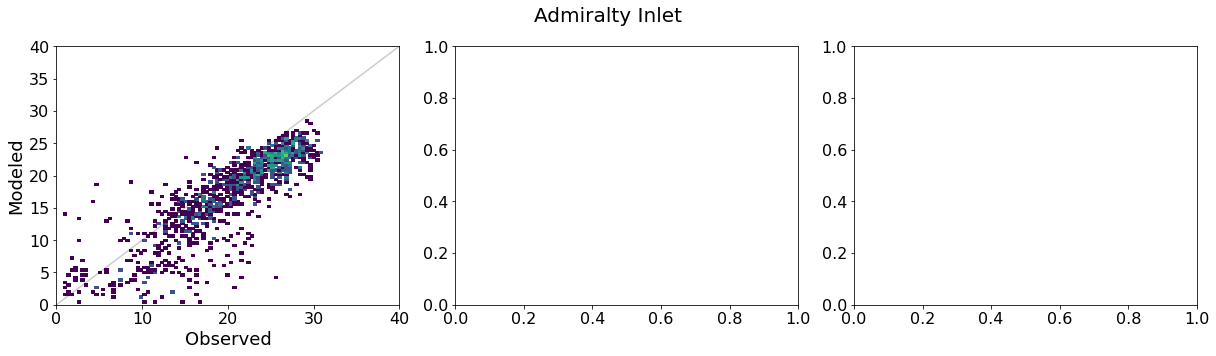

In [66]:
fig, ax = plt.subplots(1,3,figsize= (17,5))
fig.suptitle('Admiralty Inlet',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='Admiralty Inlet'],'NO23',
                'mod_nitrate',(0,40),fontsize=18,cbticks=[1,2])

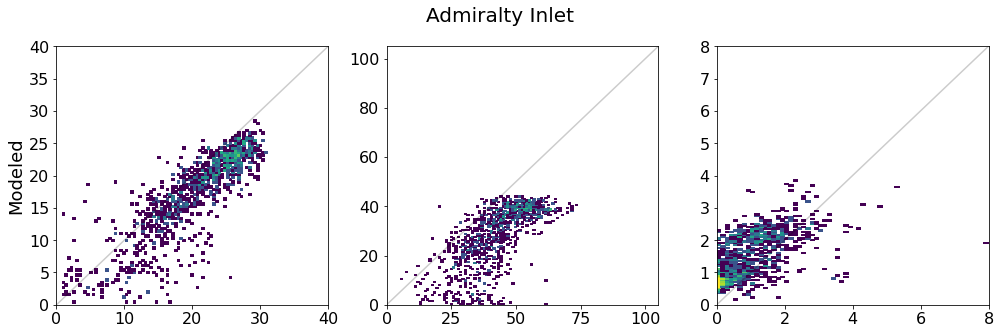

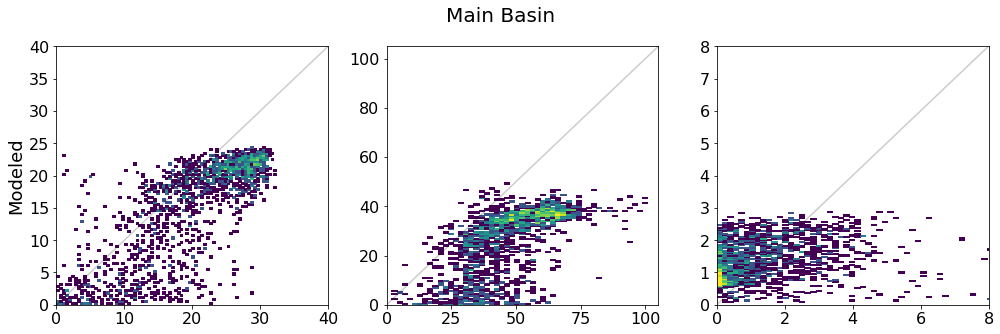

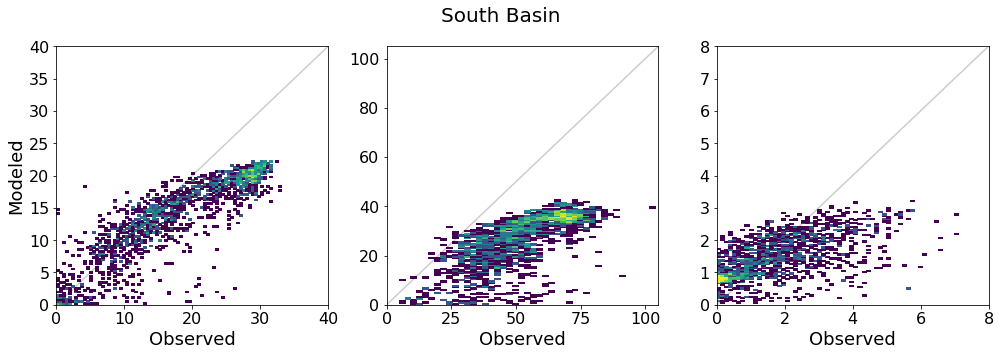

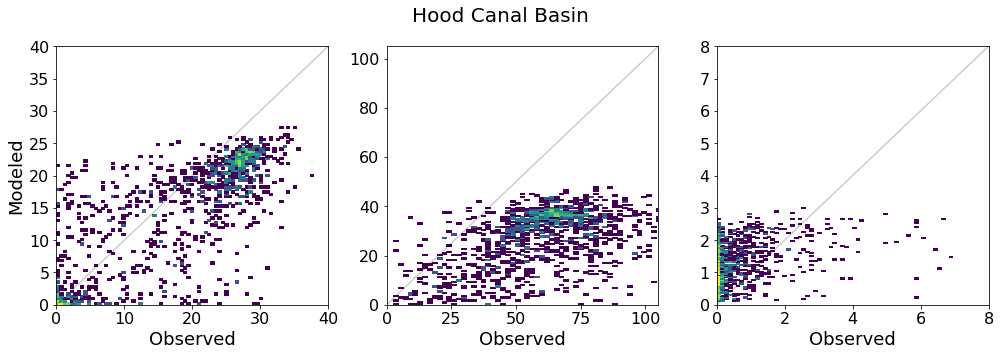

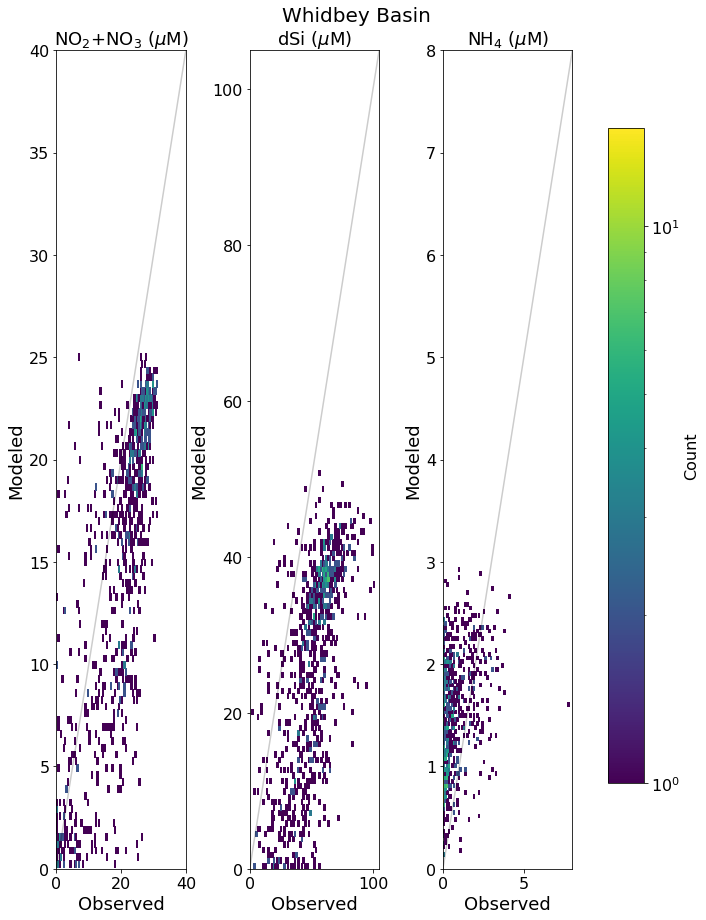

In [67]:
fig, ax = plt.subplots(1,3,figsize= (14,5))
fig.suptitle('Admiralty Inlet',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='Admiralty Inlet'],'NO23',
                'mod_nitrate',(0,40),fontsize=18,cbticks=[])
ax[0].set_xlabel('')
ax[0].set_yticks([0,5,10,15,20,25,30,35,40])

ps = hist2d(ax[1],fig,data[data.Basin=='Admiralty Inlet'],'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

ps = hist2d(ax[2],fig,data[data.Basin=='Admiralty Inlet'],'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_yticks([0,1,2,3,4,5,6,7,8])

fig, ax = plt.subplots(1,3,figsize= (14,5))
fig.suptitle('Main Basin',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='Main Basin'],'NO23','mod_nitrate',(0,40),fontsize=18)
ax[0].set_xlabel('')

ps = hist2d(ax[1],fig,data[data.Basin=='Main Basin'],'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

ps = hist2d(ax[2],fig,data[data.Basin=='Main Basin'],'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_xlabel('')
ax[2].set_ylabel('')

fig, ax = plt.subplots(1,3,figsize= (14,5))
fig.suptitle('South Basin',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='South Basin'],'NO23','mod_nitrate',(0,40),fontsize=18)

ps = hist2d(ax[1],fig,data[data.Basin=='South Basin'],'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_ylabel('')

ps = hist2d(ax[2],fig,data[data.Basin=='South Basin'],'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_ylabel('')

fig, ax = plt.subplots(1,3,figsize= (14,5))
fig.suptitle('Hood Canal Basin',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='Hood Canal Basin'],'NO23','mod_nitrate',(0,40),fontsize=18)

ps = hist2d(ax[1],fig,data[data.Basin=='Hood Canal Basin'],'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_ylabel('')

ps = hist2d(ax[2],fig,data[data.Basin=='Hood Canal Basin'],'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_ylabel('')

fig, ax = plt.subplots(1,3,figsize= (10,13))
fig.suptitle('Whidbey Basin',fontsize=20)
ps = hist2d(ax[0],fig,data[data.Basin=='Whidbey Basin'],'NO23','mod_nitrate',(0,40),fontsize=18)
ax[0].set_title('NO$_2$+NO$_3$ ($\mu$M)',fontsize=18)

ps = hist2d(ax[1],fig,data[data.Basin=='Whidbey Basin'],'Si','mod_silicon',(0,105),fontsize=18)
ax[1].set_title('dSi ($\mu$M)',fontsize=18)

ps = hist2d(ax[2],fig,data[data.Basin=='Whidbey Basin'],'Amm','mod_ammonium',(0,8),fontsize=18)
ax[2].set_title('NH$_4$ ($\mu$M)',fontsize=18)
#I think all I need to do for this is get rid of lots of labels and I should be good. 

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb=fig.colorbar(ps,cax=cbar_ax,shrink=0.5,label='Count')

In [79]:
def SAvsNut(ax,fig,df,nutrient,salinity,lims,fontsize=12,cbticks=[],nut_title=''):
    ii=(~np.isnan(df[nutrient]))&(~np.isnan(df[salinity]))
    counts, xedges, yedges, ps=ax.hist2d(df.loc[ii,[nutrient]].values.flatten(),
                                      df.loc[ii,[salinity]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,shrink=0.5)
    if len(cbticks) != 0:
        cb.set_ticks(cbticks)
    cb.set_label(label='Count',size=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim((0,40))
    ax.set_ylabel('Absolute Salinity (g/kg)',fontsize=fontsize)
    ax.set_xlabel(f'{nut_title}',fontsize=fontsize)
    plt.tight_layout()
    return ps  

## Salinity vs Nitrates

Text(0.5, 1.0, 'Observed')

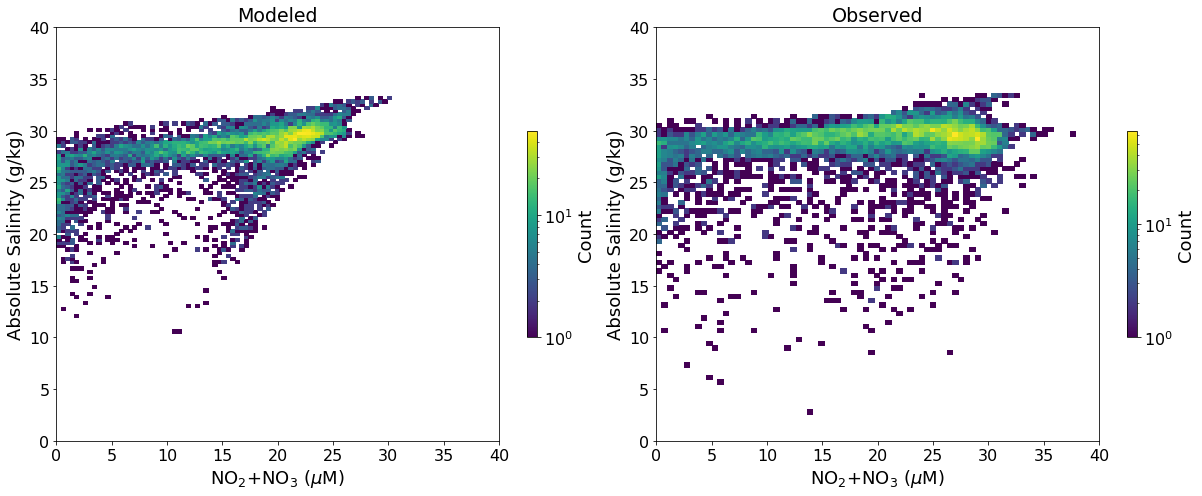

In [87]:
fig, ax = plt.subplots(1,2,figsize= (17,7))
ps = SAvsNut(ax[0],fig,data,'mod_nitrate','mod_vosaline',(0,40),fontsize=18,nut_title='NO$_2$+NO$_3$ ($\mu$M)')
ax[0].set_title('Modeled',fontsize=19)

ps = SAvsNut(ax[1],fig,data,'NO23','SA',(0,40),fontsize=18,nut_title='NO$_2$+NO$_3$ ($\mu$M)')
ax[1].set_title('Observed',fontsize=19)

## Salinity vs Silicon

Text(0.5, 1.0, 'Observed')

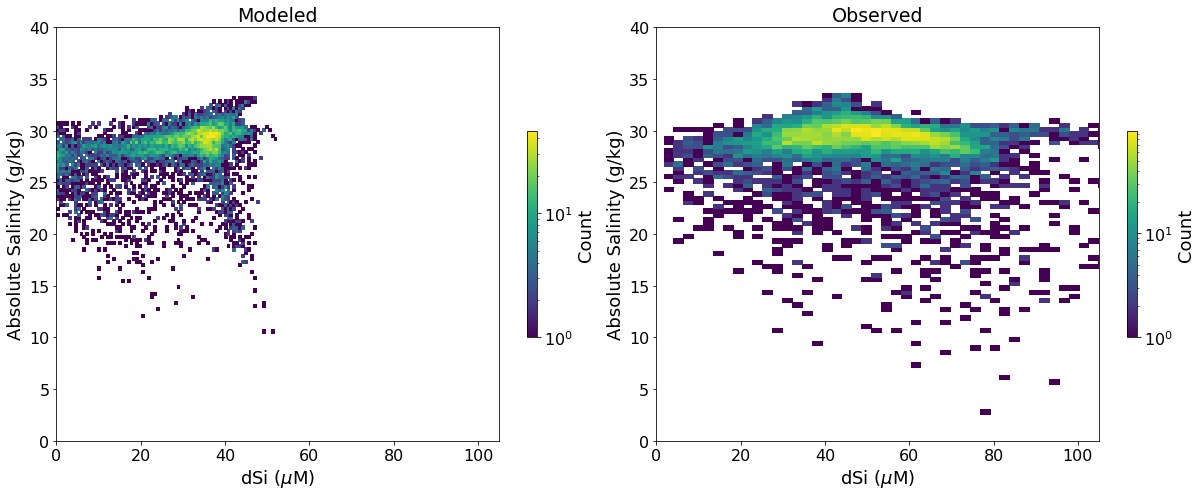

In [88]:
fig, ax = plt.subplots(1,2,figsize= (17,7))
ps = SAvsNut(ax[0],fig,data,'mod_silicon','mod_vosaline',(0,105),fontsize=18,nut_title='dSi ($\mu$M)')
ax[0].set_title('Modeled',fontsize=19)
ps = SAvsNut(ax[1],fig,data,'Si','SA',(0,105),fontsize=18,nut_title='dSi ($\mu$M)')
ax[1].set_title('Observed',fontsize=19)